<a href="https://colab.research.google.com/github/Jwangombe11/load-shortfall-regression-predict-api/blob/master/Copy_of_2110ACDS_VM13(final)_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Predict Student Solution

© Explore Data Science Academy

---
### Honour Code

I {**YOUR NAME, YOUR SURNAME**}, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

### Predict Overview: Spain Electricity Shortfall Challenge

The government of Spain is considering an expansion of it's renewable energy resource infrastructure investments. As such, they require information on the trends and patterns of the countries renewable sources and fossil fuel energy generation. Your company has been awarded the contract to:

- 1. analyse the supplied data;
- 2. identify potential errors in the data and clean the existing data set;
- 3. determine if additional features can be added to enrich the data set;
- 4. build a model that is capable of forecasting the three hourly demand shortfalls;
- 5. evaluate the accuracy of the best machine learning model;
- 6. determine what features were most important in the model’s prediction decision, and
- 7. explain the inner working of the model to a non-technical audience.

Formally the problem statement was given to you, the senior data scientist, by your manager via email reads as follow:

> In this project you are tasked to model the shortfall between the energy generated by means of fossil fuels and various renewable sources - for the country of Spain. The daily shortfall, which will be referred to as the target variable, will be modelled as a function of various city-specific weather features such as `pressure`, `wind speed`, `humidity`, etc. As with all data science projects, the provided features are rarely adequate predictors of the target variable. As such, you are required to perform feature engineering to ensure that you will be able to accurately model Spain's three hourly shortfalls.
 
On top of this, she has provided you with a starter notebook containing vague explanations of what the main outcomes are. 

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>



In [ ]:
# Libraries for data loading, data manipulation and data visulisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Libraries for data preparation and model building
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectFromModel,RFECV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score 
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from statsmodels.graphics.gofplots import qqplot

# Setting global constants to ensure notebook results are reproducible
#PARAMETER_CONSTANT = ###

<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>



In [ ]:
df = pd.read_csv('df_train.csv') # load the train data
df.head() 

Unnamed: 0                 time  ...  Madrid_temp_min load_shortfall_3h
0           0  2015-01-01 03:00:00  ...       265.938000       6715.666667
1           1  2015-01-01 06:00:00  ...       266.386667       4171.666667
2           2  2015-01-01 09:00:00  ...       272.708667       4274.666667
3           3  2015-01-01 12:00:00  ...       281.895219       5075.666667
4           4  2015-01-01 15:00:00  ...       280.678437       6620.666667

[5 rows x 49 columns]

*Importing a csv file which contains the training data*

In [ ]:
df.shape

(8763, 49)

*The train data has 8763 rows and 49 columns*

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 49 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            8763 non-null   int64  
 1   time                  8763 non-null   object 
 2   Madrid_wind_speed     8763 non-null   float64
 3   Valencia_wind_deg     8763 non-null   object 
 4   Bilbao_rain_1h        8763 non-null   float64
 5   Valencia_wind_speed   8763 non-null   float64
 6   Seville_humidity      8763 non-null   float64
 7   Madrid_humidity       8763 non-null   float64
 8   Bilbao_clouds_all     8763 non-null   float64
 9   Bilbao_wind_speed     8763 non-null   float64
 10  Seville_clouds_all    8763 non-null   float64
 11  Bilbao_wind_deg       8763 non-null   float64
 12  Barcelona_wind_speed  8763 non-null   float64
 13  Barcelona_wind_deg    8763 non-null   float64
 14  Madrid_clouds_all     8763 non-null   float64
 15  Seville_wind_speed   

*The train data has a total of 49 columns of which 47 are features columns, 1 target column which is the load_shortfall_3h and an unnamed column. The time, Valencia_wind_deg and Seville_pressure indicating presence of text or mixed numeric and non-numeric values. The unnamed column is of the int64 indicating integers and the other 45 columns are of float64 datatype indicating floating point numbers.There are some inconstitencies with some of the columns i.e. the wind degree and pressure columns are supposed to have the category datatypes. Valencia_pressure has 6695 rows instead of 8763 meaning it has null values*

In [ ]:
cat_variables = []
for j in df.columns:
    if 'wind_deg'  in df[j].name or 'pressure' in df[j].name:
        cat_variables.append(df[j].name)
        
cat_variables

['Valencia_wind_deg',
 'Bilbao_wind_deg',
 'Barcelona_wind_deg',
 'Seville_pressure',
 'Barcelona_pressure',
 'Bilbao_pressure',
 'Valencia_pressure',
 'Madrid_pressure']

*Using a for loop to obtain all the categorical variables in our train dataset and storing them in a variable called cat_variables*

In [ ]:
df['Valencia_wind_deg'].unique()

array(['level_5', 'level_10', 'level_9', 'level_8', 'level_7', 'level_6',
       'level_4', 'level_3', 'level_1', 'level_2'], dtype=object)

*Checking unique values in feature Valencia_wind_deg*

In [ ]:
df['Seville_pressure'].unique()

array(['sp25', 'sp23', 'sp24', 'sp21', 'sp16', 'sp9', 'sp15', 'sp19',
       'sp22', 'sp11', 'sp8', 'sp4', 'sp6', 'sp13', 'sp17', 'sp20',
       'sp18', 'sp14', 'sp12', 'sp5', 'sp10', 'sp7', 'sp3', 'sp2', 'sp1'],
      dtype=object)

*Checking unique values in feature Seville_pressure*

In [ ]:
df['Unnamed: 0'].unique()

array([   0,    1,    2, ..., 8760, 8761, 8762])

*Checking unique values in feature Unnamed : 0*

In [ ]:
sub_df = df[['Unnamed: 0','Valencia_wind_deg','Seville_pressure']]
df_2 = df.drop(columns = ['Unnamed: 0','Valencia_wind_deg','Seville_pressure'],inplace = True)

*Removing the three features from the dataframe*

In [ ]:
df.shape

(8763, 46)

*Confirming that the features have been dropped,by checking if the number of columns has dropped by 3*

<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>




**Data statistics**

In [ ]:
df.describe().T

count          mean  ...           75%           max
Madrid_wind_speed     8763.0      2.425729  ...      3.333333  1.300000e+01
Bilbao_rain_1h        8763.0      0.135753  ...      0.100000  3.000000e+00
Valencia_wind_speed   8763.0      2.586272  ...      3.666667  5.200000e+01
Seville_humidity      8763.0     62.658793  ...     82.000000  1.000000e+02
Madrid_humidity       8763.0     57.414717  ...     78.666667  1.000000e+02
Bilbao_clouds_all     8763.0     43.469132  ...     75.000000  1.000000e+02
Bilbao_wind_speed     8763.0      1.850356  ...      2.666667  1.266667e+01
Seville_clouds_all    8763.0     13.714748  ...     20.000000  9.733333e+01
Bilbao_wind_deg       8763.0    158.957511  ...    234.000000  3.593333e+02
Barcelona_wind_speed  8763.0      2.870497  ...      4.000000  1.266667e+01
Barcelona_wind_deg    8763.0    190.544848  ...    260.000000  3.600000e+02
Madrid_clouds_all     8763.0     19.473392  ...     33.333333  1.000000e+02
Seville_wind_speed    8763.0      2.425045  ...      3.333333  1.166667e+01
Barcelona_rain_1h     8763.0      0.128906  ...      0.000000  1.200000e+01
Seville_rain_1h       8763.0      0.039439  ...      0.000000  3.000000e+00
Bilbao_snow_3h        8763.0      0.031912  ...      0.000000  2.130000e+01
Barcelona_pressure    8763.0   1377.964605  ...   1022.000000  1.001411e+06
Seville_rain_3h       8763.0      0.000243  ...      0.000000  9.333333e-02
Madrid_rain_1h        8763.0      0.037818  ...      0.000000  3.000000e+00
Barcelona_rain_3h     8763.0      0.000439  ...      0.000000  9.300000e-02
Valencia_snow_3h      8763.0      0.000205  ...      0.000000  7.916667e-01
Madrid_weather_id     8763.0    773.527594  ...    800.666667  8.040000e+02
Barcelona_weather_id  8763.0    765.979687  ...    801.000000  8.040000e+02
Bilbao_pressure       8763.0   1017.739549  ...   1024.000000  1.042000e+03
Seville_weather_id    8763.0    774.658818  ...    800.000000  8.040000e+02
Valencia_pressure     6695.0   1012.051407  ...   1018.000000  1.021667e+03
Seville_temp_max      8763.0    297.479527  ...    304.150000  3.204833e+02
Madrid_pressure       8763.0   1010.316920  ...   1022.000000  1.038000e+03
Valencia_temp_max     8763.0    291.337233  ...    297.248333  3.142633e+02
Valencia_temp         8763.0    290.592152  ...    296.056667  3.104267e+02
Bilbao_weather_id     8763.0    724.722362  ...    801.666667  8.040000e+02
Seville_temp          8763.0    293.978903  ...    299.620333  3.149767e+02
Valencia_humidity     8763.0     65.247727  ...     81.333333  1.000000e+02
Valencia_temp_min     8763.0    289.867648  ...    294.820000  3.102720e+02
Barcelona_temp_max    8763.0    291.157644  ...    296.855000  3.140767e+02
Madrid_temp_max       8763.0    289.540309  ...    296.816667  3.144833e+02
Barcelona_temp        8763.0    289.855459  ...    294.909000  3.073167e+02
Bilbao_temp_min       8763.0    285.017973  ...    289.816667  3.098167e+02
Bilbao_temp           8763.0    286.422929  ...    291.034167  3.107100e+02
Barcelona_temp_min    8763.0    288.447422  ...    292.966667  3.048167e+02
Bilbao_temp_max       8763.0    287.966027  ...    292.483333  3.179667e+02
Seville_temp_min      8763.0    291.633356  ...    297.150000  3.148167e+02
Madrid_temp           8763.0    288.419439  ...    295.154667  3.131333e+02
Madrid_temp_min       8763.0    287.202203  ...    293.884500  3.103833e+02
load_shortfall_3h     8763.0  10673.857612  ...  14498.166667  3.190400e+04

[45 rows x 8 columns]

*Bilbao_rain_1h, Barcelona_rain_1h, Seville_rain_1h, Bilbao_snow_3h, Seville_rain_3h, Madrid_rain_1h, Barcelona_rain_3h, Valencia_snow_3h have a zero value for the minimum value, 25 percentile value, median value and 75 percentile value.*

**Evaluate correlation**

Text(0.5, 1.0, 'Correlation Heatmap')

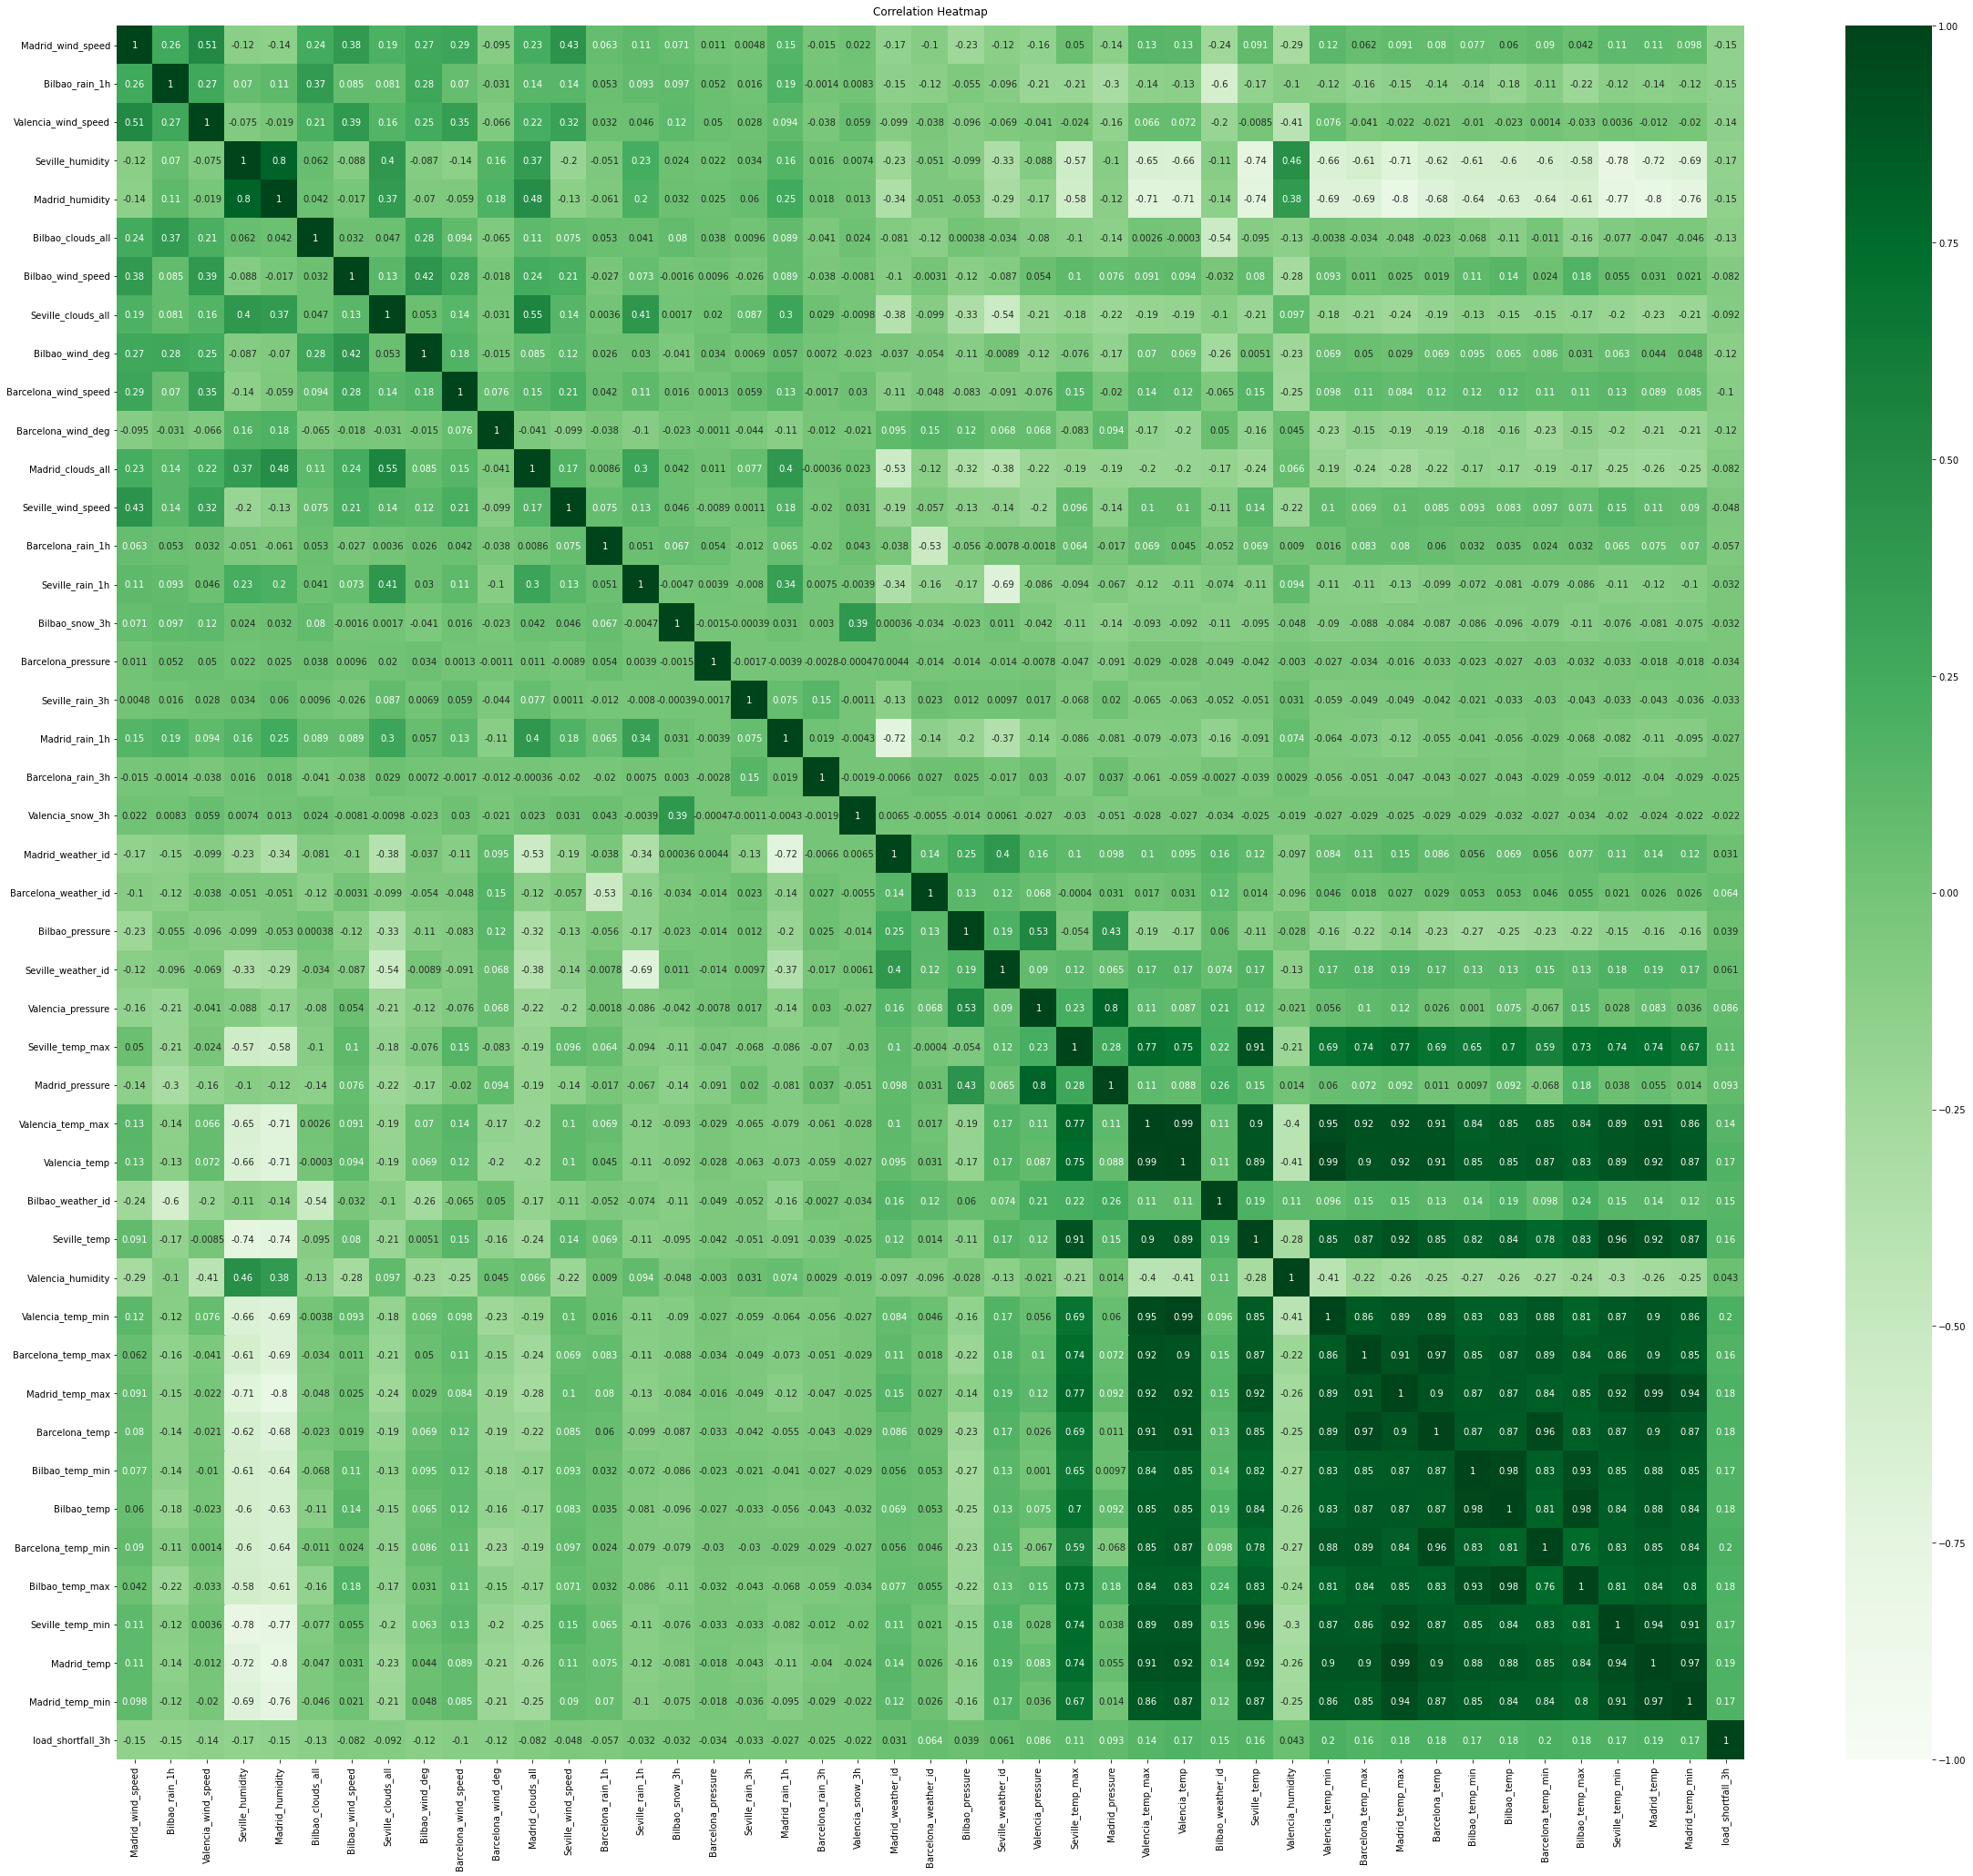

In [ ]:
plt.figure(figsize=(40, 35))
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
df_corr = df.corr()
heatmap = sns.heatmap(df_corr,  vmin=-1,vmax=1, annot=True,cmap = 'Greens')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

*The light green shade indicate that the high negative correlation and dark greens indicate high positive correlation. Most of the temperature variables from different cities have a positive correlation. Seville humidity and Madrid humidity have a negative correlation with the temperature variables*

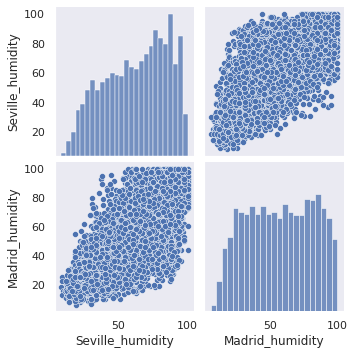

In [ ]:
positive_corr = sns.pairplot(df, vars=["Seville_humidity", "Madrid_humidity"])

*Positive correlation between Seville humidity and Madrid humidity.*

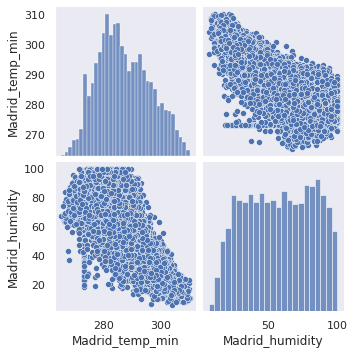

In [ ]:
negative_corr = sns.pairplot(df, vars=["Madrid_temp_min", "Madrid_humidity"])

*Negative correlation between Madrid_temp_min and Madrid_humidity.*

**Feature distributions**

In [ ]:

def plot_func(df):
    
    for col in df.columns:
        if df[col].dtype == float or df[col].dtype == int:
            f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (1, 5)})
            mean=np.array(df[col]).mean()
            median=np.median(df[col])
            
            sns.boxplot(df[col], ax=ax_box)
            ax_box.axvline(mean, color='r', linestyle='--')
            ax_box.axvline(median, color='g', linestyle='-')
            
            sns.distplot(df[col], ax=ax_hist)
            ax_hist.axvline(mean, color='r', linestyle='--')
            ax_hist.axvline(median, color='g', linestyle='-')
            
            plt.legend({'Mean':mean,'Median':median})
            ax_box.set(xlabel='')
            plt.show()

            print('Skewness :',df[col].skew())
            print('Kurtosis :',df[col].kurtosis())
            
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3-q1
            print('Lower quartile ', q1)
            print('Upper quartile ', q3)
            print('Inter quartile range ', iqr)

            lower_whisker = q1 - (1.5 * iqr)
            upper_whisker = q3 + (1.5 * iqr)
            print('lower_whisker ', lower_whisker)
            print('upper_whisker', upper_whisker)

            print(np.array((np.where((df[col]<lower_whisker) | (df[col]>upper_whisker)))).shape)

*A function that encapsules univariate analysis of each numerical variable. In terms of graphical analysis it displays two plots: boxplot - One can be able to establish if a particular variable has outliers or not. More to that one is able to establish the mean,median upper quartile,lower quartile of each feature Distplot - It shows the distribution of each variable In terms of non-graphical analysis one can be to tell: The skewness of each variable, The kurtosis Lower quartile,lower whisker,upper quartile,upper quartile and interquartile range are quantified The last tuple displays how many data points are considered as outliers.*

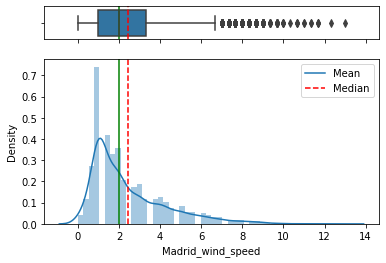

Skewness : 1.4411442292107193
Kurtosis : 2.0364621246675885
Lower quartile  1.0
Upper quartile  3.3333333333
Inter quartile range  2.3333333333
lower_whisker  -2.49999999995
upper_whisker 6.83333333325
(1, 307)


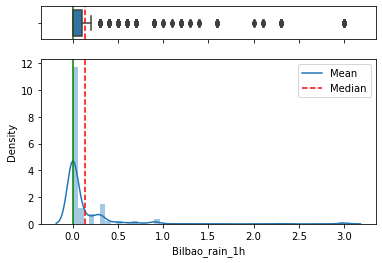

Skewness : 5.222801989732795
Kurtosis : 32.90465647123472
Lower quartile  0.0
Upper quartile  0.1
Inter quartile range  0.1
lower_whisker  -0.15000000000000002
upper_whisker 0.25
(1, 1576)


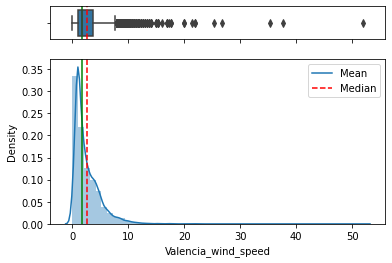

Skewness : 3.499636517325859
Kurtosis : 35.645426386267474
Lower quartile  1.0
Upper quartile  3.6666666667
Inter quartile range  2.6666666667
lower_whisker  -3.00000000005
upper_whisker 7.66666666675
(1, 327)


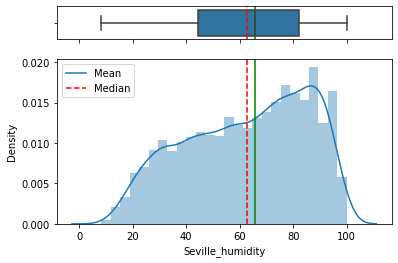

Skewness : -0.31017499809859467
Kurtosis : -1.017982770351452
Lower quartile  44.3333333333
Upper quartile  82.0
Inter quartile range  37.6666666667
lower_whisker  -12.166666666750011
upper_whisker 138.50000000005002
(1, 0)


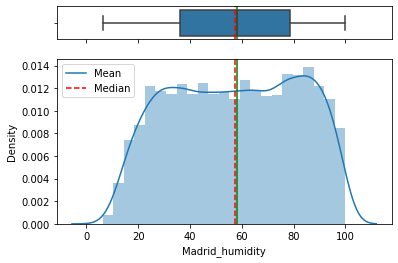

Skewness : -0.05737776957935216
Kurtosis : -1.167537310965867
Lower quartile  36.3333333333
Upper quartile  78.6666666667
Inter quartile range  42.3333333334
lower_whisker  -27.166666666800005
upper_whisker 142.16666666679998
(1, 0)


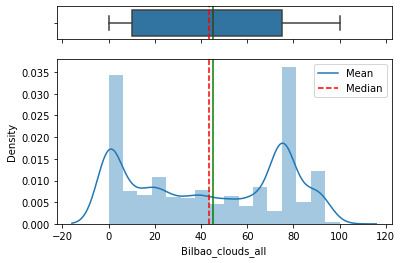

Skewness : -0.053085395425974256
Kurtosis : -1.5334170123998256
Lower quartile  10.0
Upper quartile  75.0
Inter quartile range  65.0
lower_whisker  -87.5
upper_whisker 172.5
(1, 0)


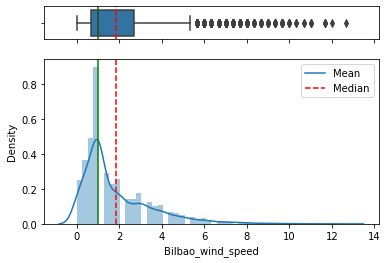

Skewness : 1.7169141154170686
Kurtosis : 3.6315653270441643
Lower quartile  0.6666666667
Upper quartile  2.6666666667
Inter quartile range  2.0
lower_whisker  -2.3333333333
upper_whisker 5.666666666699999
(1, 380)


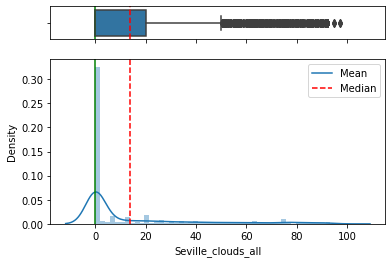

Skewness : 1.8144517925601304
Kurtosis : 2.1559210977967203
Lower quartile  0.0
Upper quartile  20.0
Inter quartile range  20.0
lower_whisker  -30.0
upper_whisker 50.0
(1, 1010)


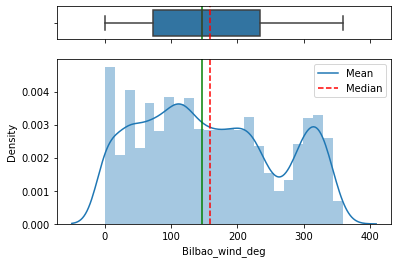

Skewness : 0.22692651432270444
Kurtosis : -1.0835298590634024
Lower quartile  73.3333333333
Upper quartile  234.0
Inter quartile range  160.6666666667
lower_whisker  -167.66666666675
upper_whisker 475.00000000005
(1, 0)


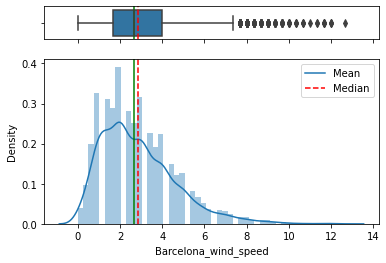

Skewness : 1.057330609573318
Kurtosis : 1.4936353085879928
Lower quartile  1.6666666667
Upper quartile  4.0
Inter quartile range  2.3333333332999997
lower_whisker  -1.8333333332499995
upper_whisker 7.499999999949999
(1, 180)


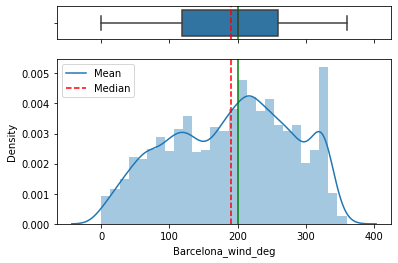

Skewness : -0.1800013211348048
Kurtosis : -0.9591599001218869
Lower quartile  118.16666666665
Upper quartile  260.0
Inter quartile range  141.83333333335
lower_whisker  -94.58333333337501
upper_whisker 472.750000000025
(1, 0)


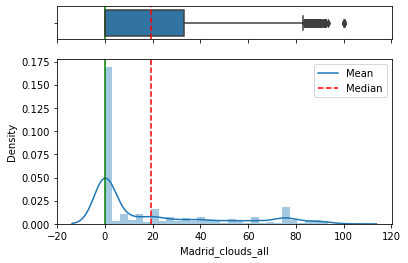

Skewness : 1.2467446252828802
Kurtosis : 0.14207863141425037
Lower quartile  0.0
Upper quartile  33.3333333333
Inter quartile range  33.3333333333
lower_whisker  -49.99999999994999
upper_whisker 83.33333333324998
(1, 310)


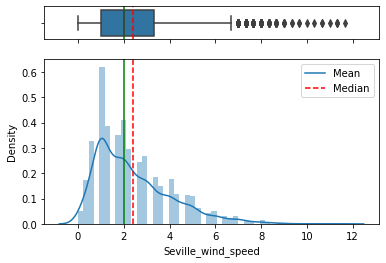

Skewness : 1.151005838368391
Kurtosis : 1.398579537584049
Lower quartile  1.0
Upper quartile  3.3333333333
Inter quartile range  2.3333333333
lower_whisker  -2.49999999995
upper_whisker 6.83333333325
(1, 186)


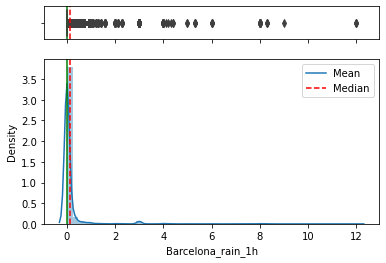

Skewness : 8.726987596141935
Kurtosis : 101.5789308218838
Lower quartile  0.0
Upper quartile  0.0
Inter quartile range  0.0
lower_whisker  0.0
upper_whisker 0.0
(1, 1297)


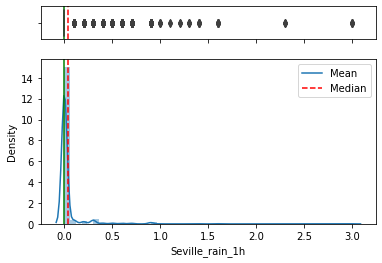

Skewness : 8.067341341966005
Kurtosis : 93.84074607373714
Lower quartile  0.0
Upper quartile  0.0
Inter quartile range  0.0
lower_whisker  0.0
upper_whisker 0.0
(1, 854)


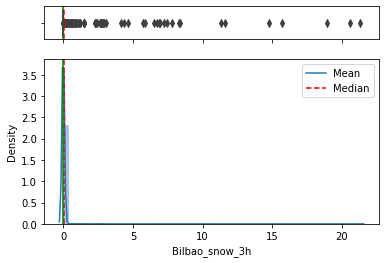

Skewness : 26.17756798977392
Kurtosis : 806.1284706376119
Lower quartile  0.0
Upper quartile  0.0
Inter quartile range  0.0
lower_whisker  0.0
upper_whisker 0.0
(1, 97)


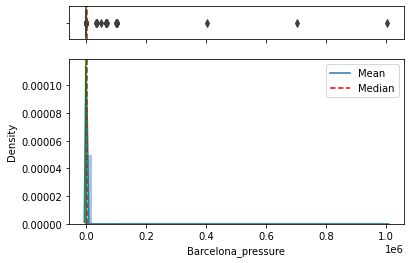

Skewness : 57.97966391220743
Kurtosis : 3687.5642300069417
Lower quartile  1014.0
Upper quartile  1022.0
Inter quartile range  8.0
lower_whisker  1002.0
upper_whisker 1034.0
(1, 349)


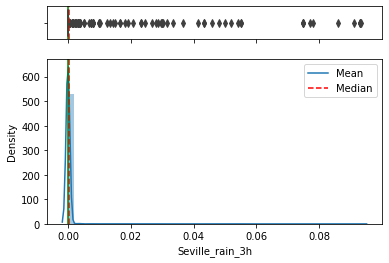

Skewness : 19.342573910601818
Kurtosis : 413.1365923500452
Lower quartile  0.0
Upper quartile  0.0
Inter quartile range  0.0
lower_whisker  0.0
upper_whisker 0.0
(1, 90)


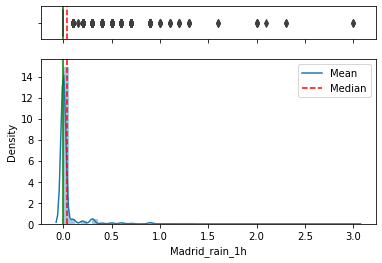

Skewness : 7.074307665706903
Kurtosis : 76.5844913665545
Lower quartile  0.0
Upper quartile  0.0
Inter quartile range  0.0
lower_whisker  0.0
upper_whisker 0.0
(1, 928)


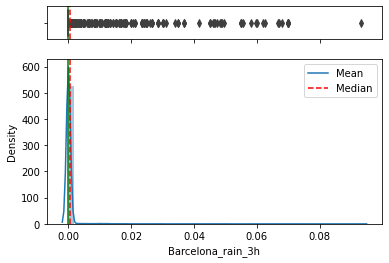

Skewness : 12.696605470731132
Kurtosis : 187.8004595033525
Lower quartile  0.0
Upper quartile  0.0
Inter quartile range  0.0
lower_whisker  0.0
upper_whisker 0.0
(1, 223)


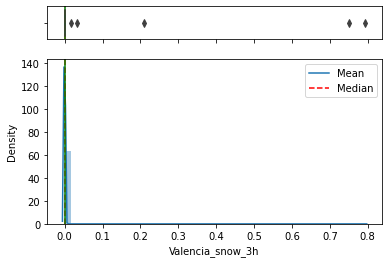

Skewness : 63.298084409477404
Kurtosis : 4089.323165482344
Lower quartile  0.0
Upper quartile  0.0
Inter quartile range  0.0
lower_whisker  0.0
upper_whisker 0.0
(1, 5)


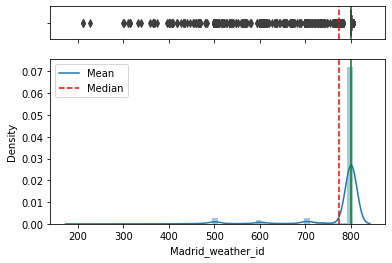

Skewness : -3.1077224640882264
Kurtosis : 9.25904651532839
Lower quartile  800.0
Upper quartile  800.6666666667
Inter quartile range  0.6666666667000527
lower_whisker  798.99999999995
upper_whisker 801.6666666667502
(1, 2385)


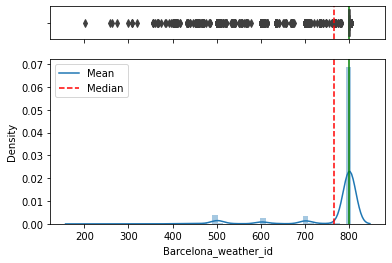

Skewness : -2.5840106243242724
Kurtosis : 5.701881572742422
Lower quartile  800.0
Upper quartile  801.0
Inter quartile range  1.0
lower_whisker  798.5
upper_whisker 802.5
(1, 2040)


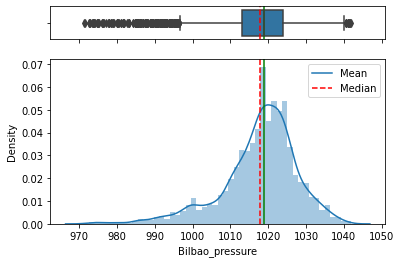

Skewness : -0.9996419604542528
Kurtosis : 1.8253225485015836
Lower quartile  1013.0
Upper quartile  1024.0
Inter quartile range  11.0
lower_whisker  996.5
upper_whisker 1040.5
(1, 365)


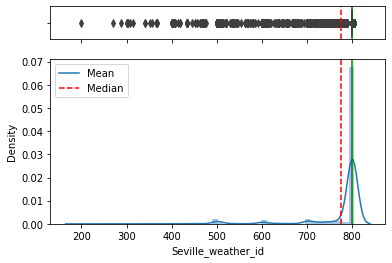

Skewness : -3.275574340057644
Kurtosis : 10.710308129580135
Lower quartile  800.0
Upper quartile  800.0
Inter quartile range  0.0
lower_whisker  800.0
upper_whisker 800.0
(1, 3484)


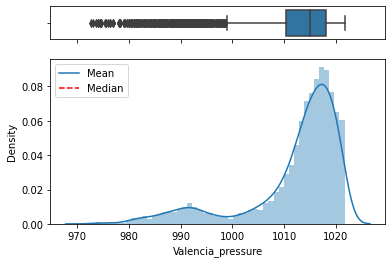

Skewness : -1.7051619012336132
Kurtosis : 2.21182335714847
Lower quartile  1010.3333333333
Upper quartile  1018.0
Inter quartile range  7.666666666700053
lower_whisker  998.8333333332498
upper_whisker 1029.50000000005
(1, 809)


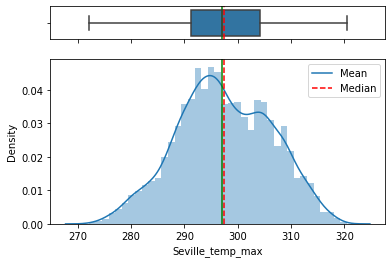

Skewness : -0.0339308264048835
Kurtosis : -0.5159894754947327
Lower quartile  291.31275000000005
Upper quartile  304.15
Inter quartile range  12.837249999999926
lower_whisker  272.05687500000016
upper_whisker 323.40587499999987
(1, 0)


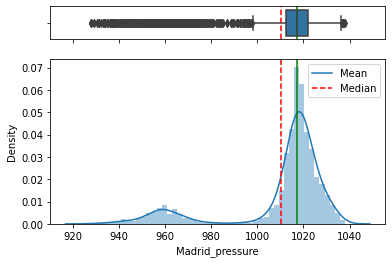

Skewness : -1.8507676181492347
Kurtosis : 2.216199344232205
Lower quartile  1012.3333333333
Upper quartile  1022.0
Inter quartile range  9.666666666700053
lower_whisker  997.8333333332498
upper_whisker 1036.50000000005
(1, 1303)


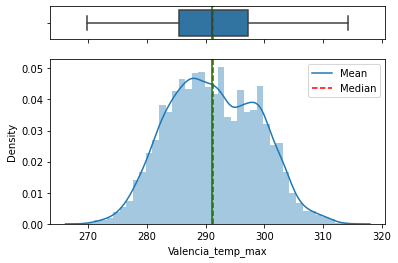

Skewness : 0.08267199320849858
Kurtosis : -0.6137547615408363
Lower quartile  285.55016666665
Upper quartile  297.24833333335
Inter quartile range  11.69816666669999
lower_whisker  268.0029166666
upper_whisker 314.7955833334
(1, 0)


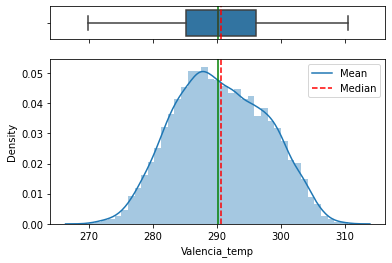

Skewness : 0.05747636574022998
Kurtosis : -0.6437930258670739
Lower quartile  285.15
Upper quartile  296.0566666667
Inter quartile range  10.906666666700005
lower_whisker  268.78999999994994
upper_whisker 312.41666666674996
(1, 0)


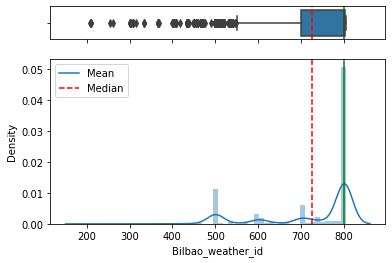

Skewness : -1.234843980657284
Kurtosis : 0.06781438947623064
Lower quartile  700.3333333333
Upper quartile  801.6666666667
Inter quartile range  101.3333333334001
lower_whisker  548.3333333331998
upper_whisker 953.6666666668002
(1, 1404)


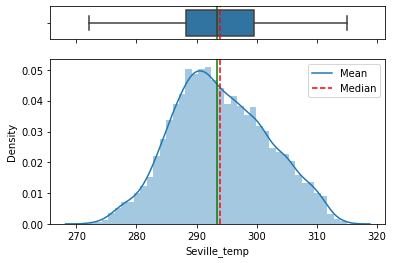

Skewness : 0.15723830205656178
Kurtosis : -0.5041322882243198
Lower quartile  288.28291666664995
Upper quartile  299.62033333335
Inter quartile range  11.33741666670005
lower_whisker  271.2767916665999
upper_whisker 316.6264583334001
(1, 0)


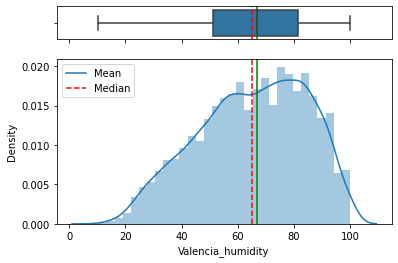

Skewness : -0.30575732882175444
Kurtosis : -0.7343454982297355
Lower quartile  51.3333333333
Upper quartile  81.3333333333
Inter quartile range  30.000000000000007
lower_whisker  6.333333333299983
upper_whisker 126.33333333330002
(1, 0)


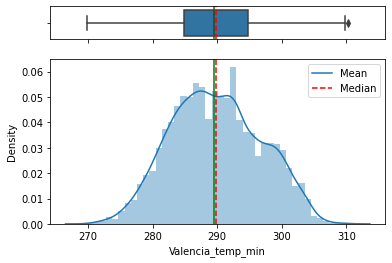

Skewness : 0.0818322233978733
Kurtosis : -0.5995506151499272
Lower quartile  284.7833333333
Upper quartile  294.82
Inter quartile range  10.0366666667
lower_whisker  269.72833333325
upper_whisker 309.87500000005
(1, 1)


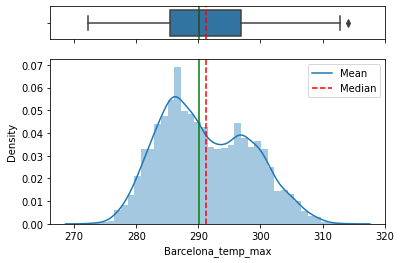

Skewness : 0.2769246414384882
Kurtosis : -0.728757385641762
Lower quartile  285.4833333333
Upper quartile  296.855
Inter quartile range  11.371666666700037
lower_whisker  268.4258333332499
upper_whisker 313.91250000005004
(1, 1)


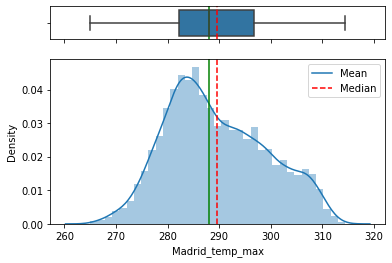

Skewness : 0.29870749813604114
Kurtosis : -0.6628611401473941
Lower quartile  282.15
Upper quartile  296.8166666667
Inter quartile range  14.666666666699996
lower_whisker  260.14999999994996
upper_whisker 318.81666666674994
(1, 0)


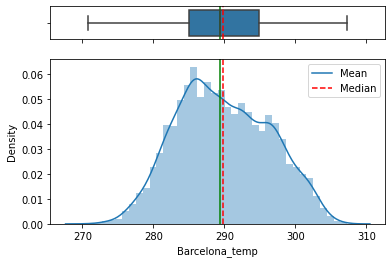

Skewness : 0.1280945706486536
Kurtosis : -0.6965548392192273
Lower quartile  284.97344270835003
Upper quartile  294.909
Inter quartile range  9.935557291649957
lower_whisker  270.0701067708751
upper_whisker 309.8123359374749
(1, 0)


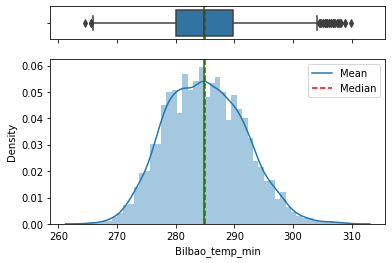

Skewness : 0.19491220408331122
Kurtosis : -0.2303421161293615
Lower quartile  280.08516666665
Upper quartile  289.8166666667
Inter quartile range  9.731500000049948
lower_whisker  265.4879166665751
upper_whisker 304.41391666677487
(1, 32)


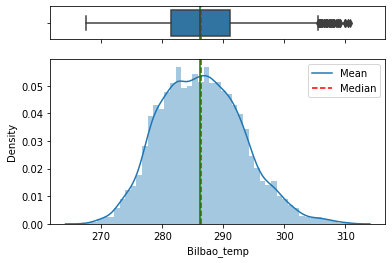

Skewness : 0.2936863815182865
Kurtosis : -0.0863625314948342
Lower quartile  281.37416666665
Upper quartile  291.03416666665
Inter quartile range  9.659999999999968
lower_whisker  266.88416666665006
upper_whisker 305.52416666664993
(1, 57)


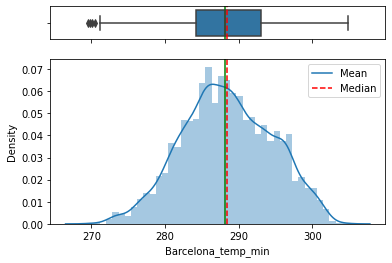

Skewness : -0.01805659274040252
Kurtosis : -0.47488983864511214
Lower quartile  284.15
Upper quartile  292.9666666667
Inter quartile range  8.81666666670003
lower_whisker  270.92499999994993
upper_whisker 306.19166666675005
(1, 4)


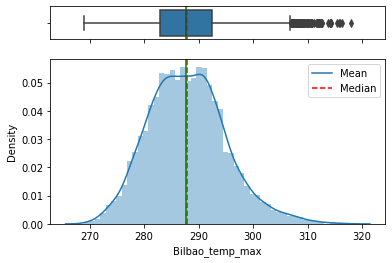

Skewness : 0.39393171665016424
Kurtosis : 0.2833664892986216
Lower quartile  282.83677604164996
Upper quartile  292.4833333333
Inter quartile range  9.646557291650026
lower_whisker  268.3669401041749
upper_whisker 306.953169270775
(1, 99)


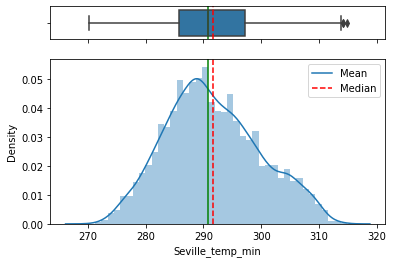

Skewness : 0.2654818767786141
Kurtosis : -0.47556416483549313
Lower quartile  285.8166666667
Upper quartile  297.15
Inter quartile range  11.333333333300004
lower_whisker  268.81666666674994
upper_whisker 314.14999999994996
(1, 3)


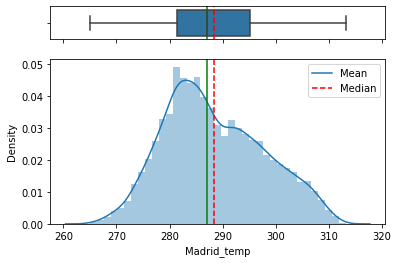

Skewness : 0.3041227308524655
Kurtosis : -0.612298600304205
Lower quartile  281.40428125
Upper quartile  295.15466666665
Inter quartile range  13.750385416649976
lower_whisker  260.778703125025
upper_whisker 315.7802447916249
(1, 0)


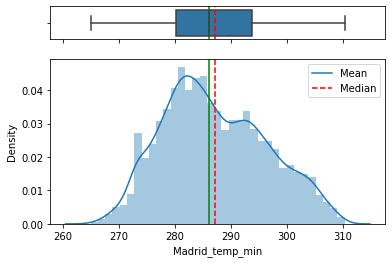

Skewness : 0.27508252382191245
Kurtosis : -0.6666462398271551
Lower quartile  280.29916666665
Upper quartile  293.8845
Inter quartile range  13.585333333349979
lower_whisker  259.921166666625
upper_whisker 314.26250000002494
(1, 0)


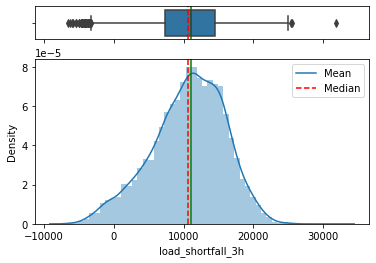

Skewness : -0.384847070902431
Kurtosis : -0.11899877049908492
Lower quartile  7390.3333333333
Upper quartile  14498.16666666665
Inter quartile range  7107.833333333349
lower_whisker  -3271.4166666667234
upper_whisker 25159.91666666667
(1, 50)


In [ ]:
plot_func(df)



1. Outliers:are values that are notably different from other data points. Presence of outliers increases: 

> *   the error variance (i.e. the difference between the predicted values and observed values) reducing the power of statistical tests. Kurtosis tests for outliers.

2. Skewness: tests by how much the overall shape of a distribution deviates from the shape of the normal distribution. Variables can be negatively or postively skewed.
*italicized text*



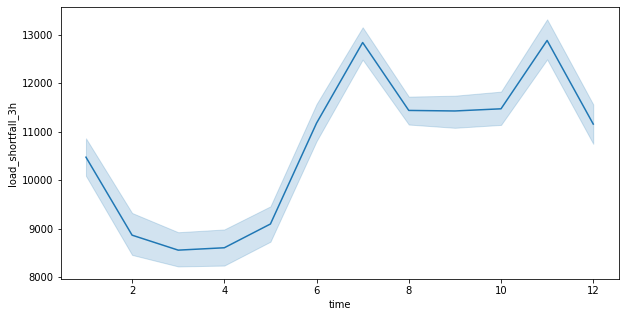

In [ ]:
plt.figure(figsize = (10,5))
sns.lineplot(x = pd.DatetimeIndex(df['time']).month, y = 'load_shortfall_3h',data = df)

*The load shortfall decreased between the months of January-February, July-August and November-December. There was a huge increase May-june and another increase between October-November.*

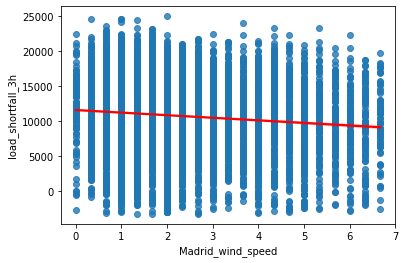

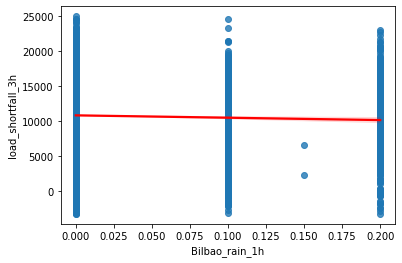

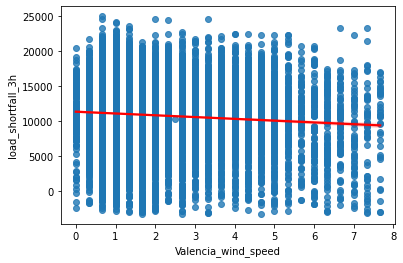

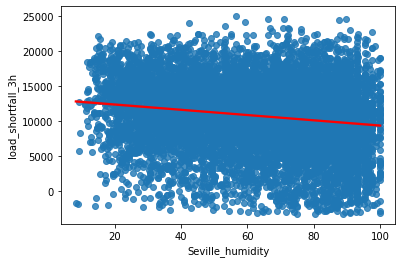

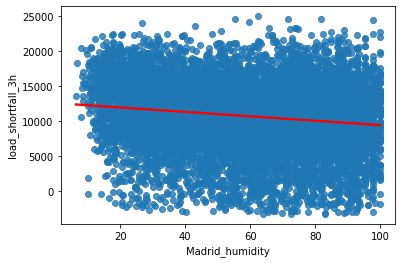

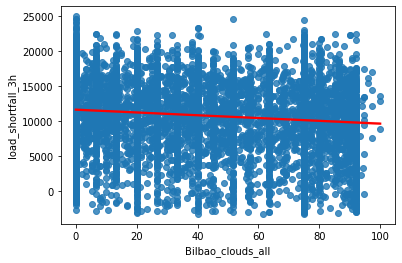

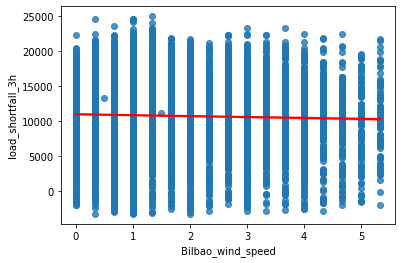

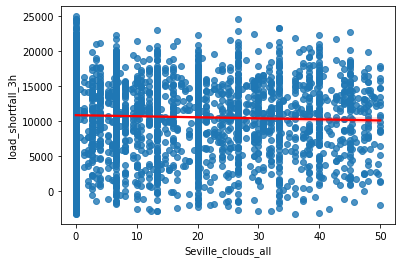

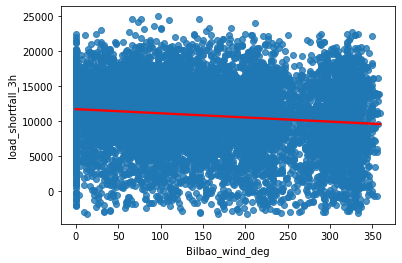

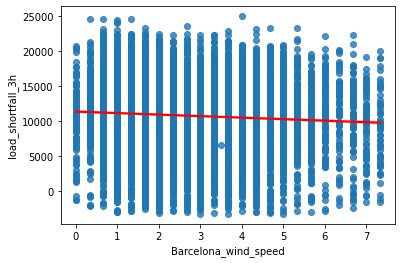

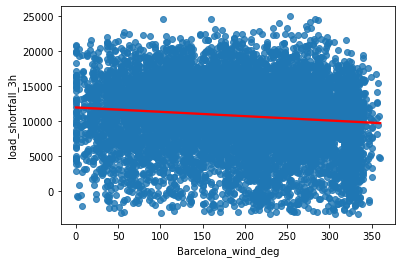

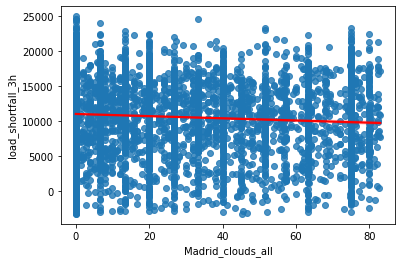

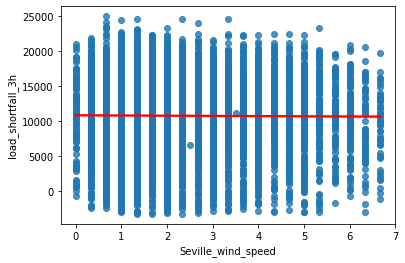

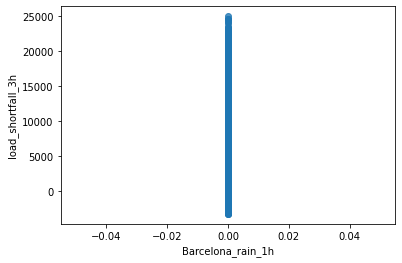

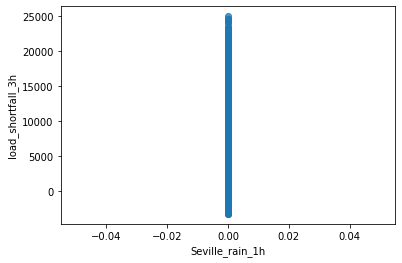

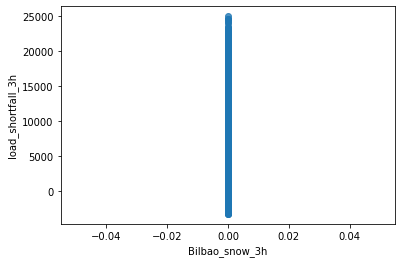

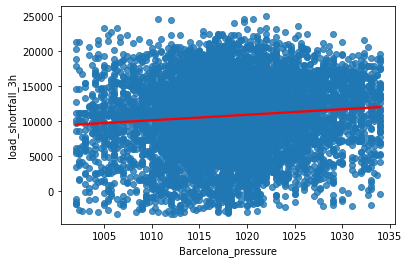

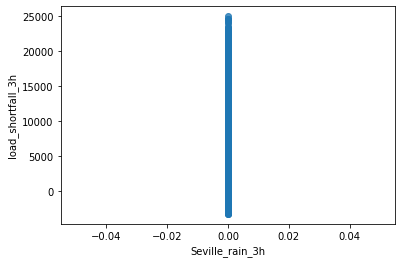

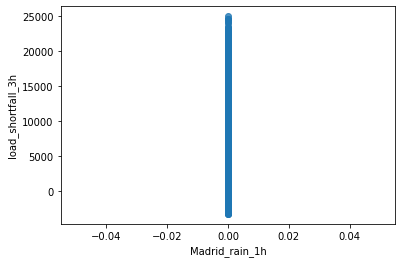

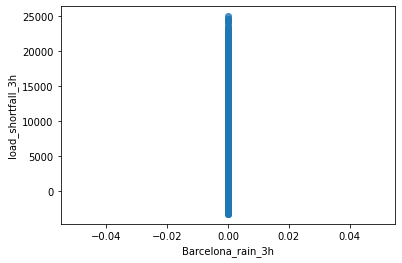

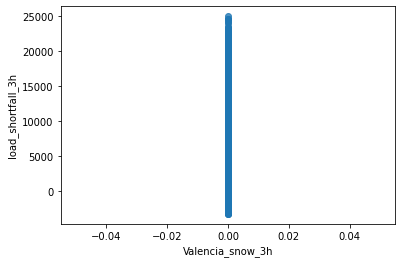

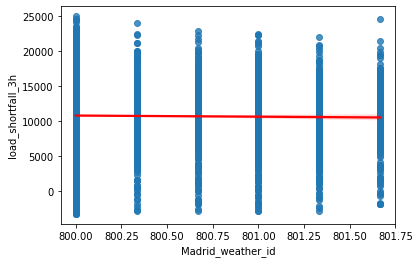

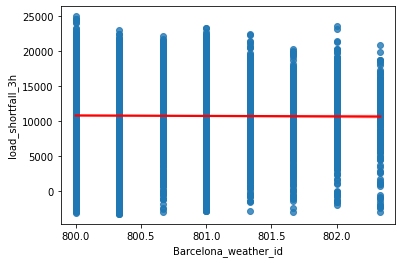

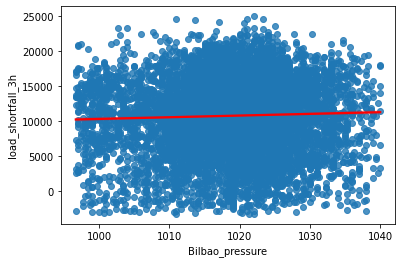

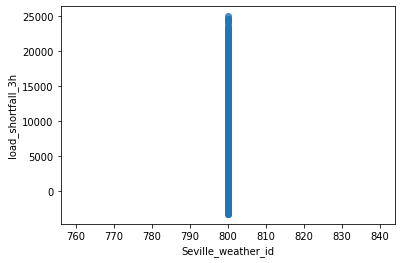

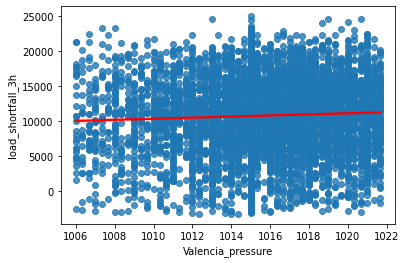

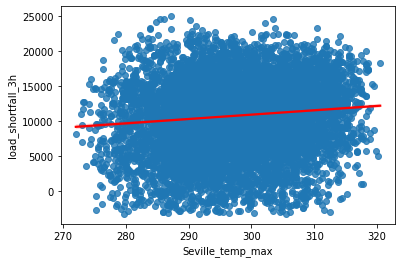

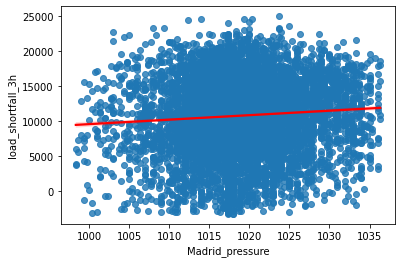

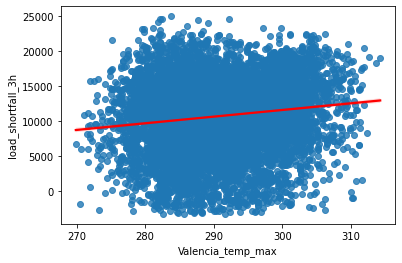

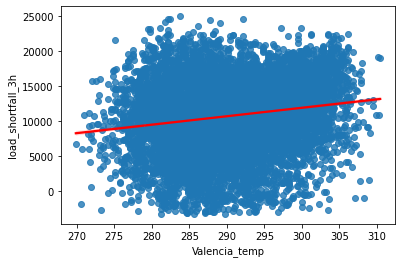

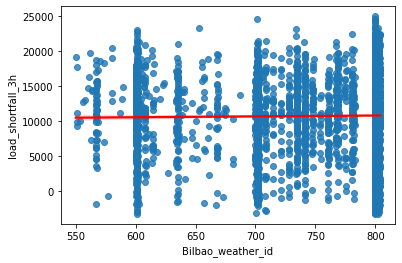

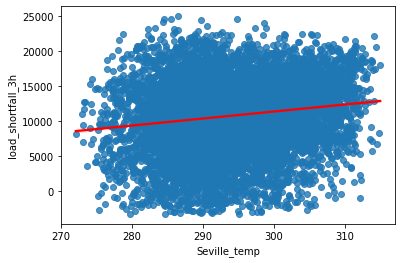

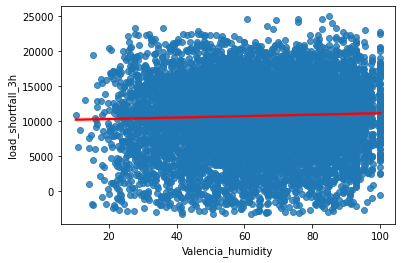

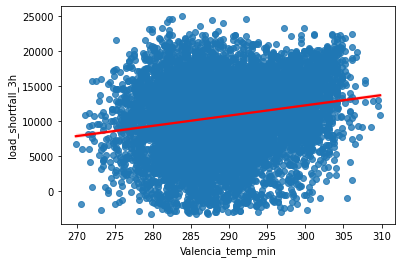

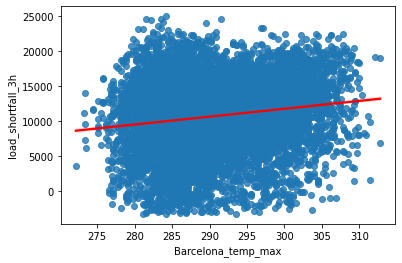

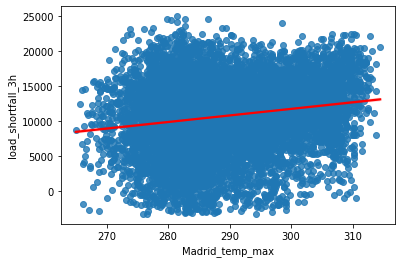

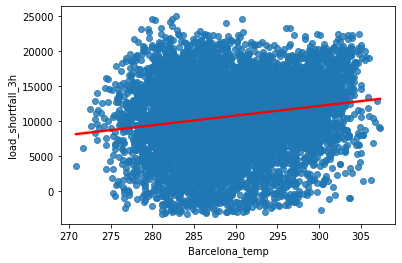

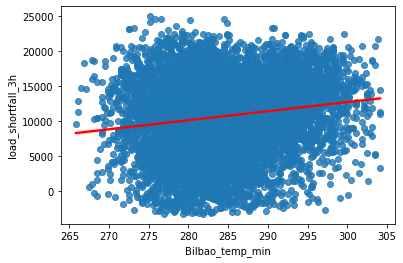

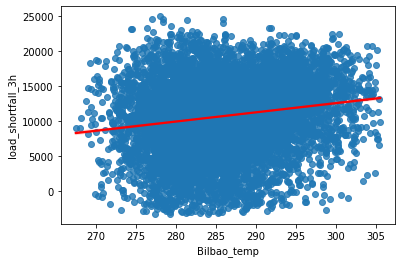

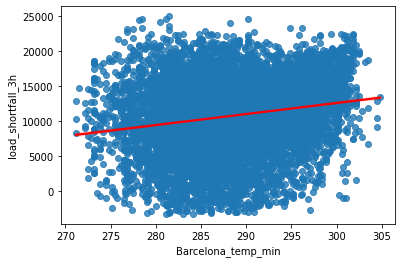

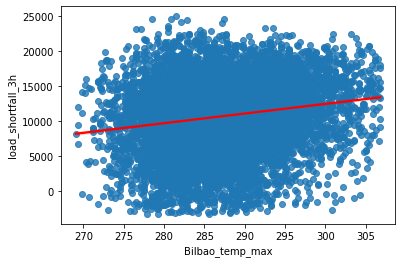

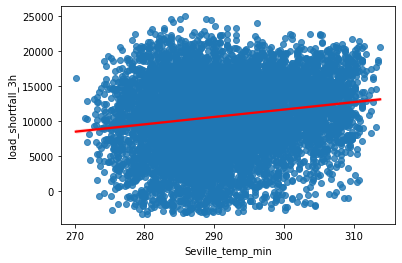

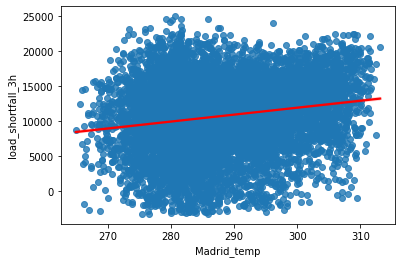

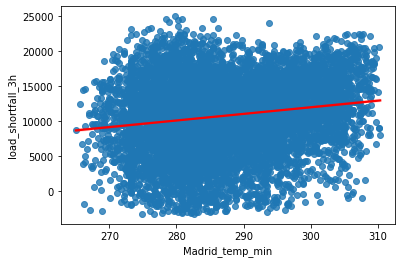

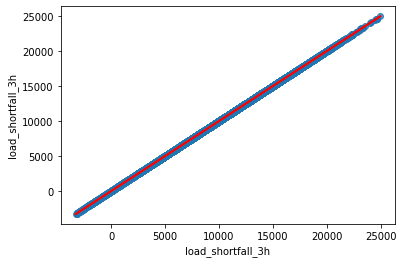

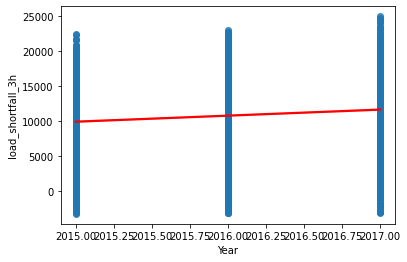

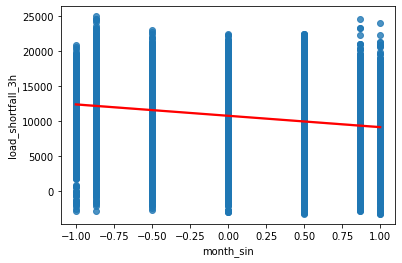

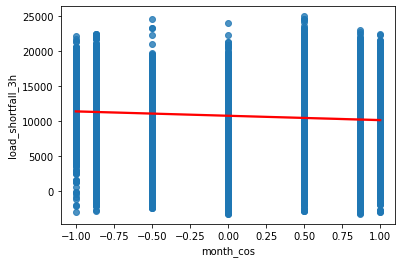

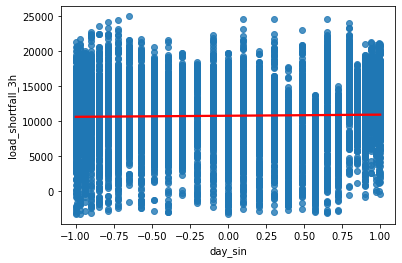

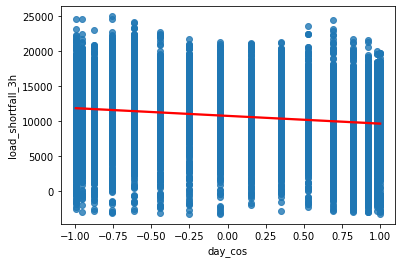

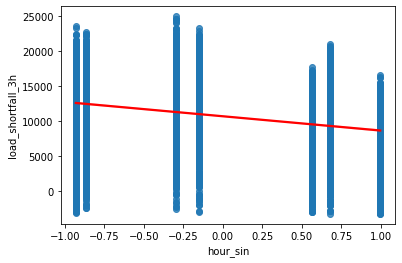

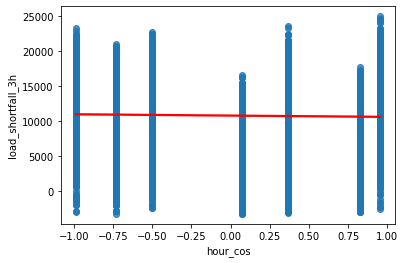

In [ ]:
#checking for linearlity
for i in df.columns:
  sns.regplot(x=df[i],y=df['load_shortfall_3h'],data = df,line_kws={"color": "red"})
  plt.show()

 *Linearity: The relationship between X and the mean of Y is linear. The relationship can either be positive(i.e. as the X variable increases the Y variable also increases) or negative(i.e.as the X variable increases the Y variable also decreases)
All the features have weak association with the target variable.*

In [ ]:
y_name = 'load_shortfall_3h'

X_names = [col for col in df.columns if col != y_name]

# Build the OLS formula string " y ~ X "
formula_str = y_name+" ~ "+" + ".join(X_names);
print('Formula:\n\t {}'.format(formula_str))

Formula:
	 load_shortfall_3h ~ time + Madrid_wind_speed + Bilbao_rain_1h + Valencia_wind_speed + Seville_humidity + Madrid_humidity + Bilbao_clouds_all + Bilbao_wind_speed + Seville_clouds_all + Bilbao_wind_deg + Barcelona_wind_speed + Barcelona_wind_deg + Madrid_clouds_all + Seville_wind_speed + Barcelona_rain_1h + Seville_rain_1h + Bilbao_snow_3h + Barcelona_pressure + Seville_rain_3h + Madrid_rain_1h + Barcelona_rain_3h + Valencia_snow_3h + Madrid_weather_id + Barcelona_weather_id + Bilbao_pressure + Seville_weather_id + Valencia_pressure + Seville_temp_max + Madrid_pressure + Valencia_temp_max + Valencia_temp + Bilbao_weather_id + Seville_temp + Valencia_humidity + Valencia_temp_min + Barcelona_temp_max + Madrid_temp_max + Barcelona_temp + Bilbao_temp_min + Bilbao_temp + Barcelona_temp_min + Bilbao_temp_max + Seville_temp_min + Madrid_temp + Madrid_temp_min


In [ ]:
# Fit the model using the model dataframe
model=ols(formula=formula_str, data=df)
fitted = model.fit()
print(fitted.summary())

*There is indication of strong multicollinearity indicating several independent variables in a model are correlated and is likely to result in less reliable statistical inferences.*

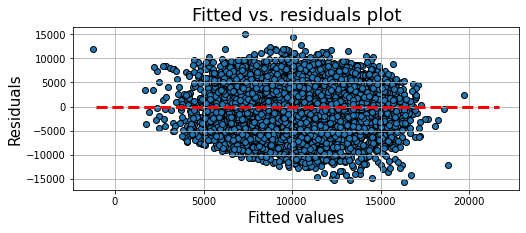

In [ ]:
plt.figure(figsize=(8,3))
p=plt.scatter(x=fitted.fittedvalues,y=fitted.resid,edgecolor='k')
xmin = min(fitted.fittedvalues)
xmax = max(fitted.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

*The scatter plot has a cone shape around the regression line indicating heteroscedasticity(i.e. when the residuals are observed to have unequal variance). It could be as a result  wide range of values which are more prone to heteroskedasticity because the differences between the smallest and largest values are so significant.*

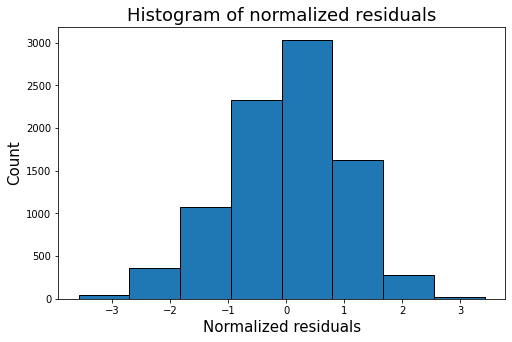

In [ ]:
#CHECKING FOR NORMALITY
plt.figure(figsize=(8,5))
plt.hist(fitted.resid_pearson,bins=8,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalized residuals',fontsize=15)
plt.title("Histogram of normalized residuals",fontsize=18)
plt.show()

<Figure size 576x360 with 0 Axes>

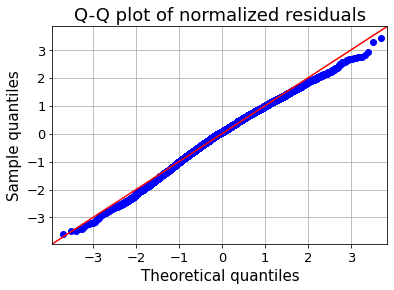

In [ ]:

plt.figure(figsize=(8,5))
fig=qqplot(fitted.resid_pearson,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalized residuals",fontsize=18)
plt.grid(True)
plt.show()

*The residuals are normally distributed meaning that the assumption of linear model is valid*

<a id="four"></a>
## 4. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>



**Remove missing values/ features**

In [ ]:
df['Valencia_pressure'].fillna(value = df['Valencia_pressure'].median(),inplace= True)
df.isnull().any().sum()

0

*Filling the null values in Valencia_pressure with the median of the column.*


**Engineer existing features**

In [ ]:
def outliers(df):
    
    for i in df.columns:
        
        if df[i].dtype == float or df[i].dtype == int: 
        
                median = df[i].median()

                q1 = df[i].quantile(0.25)
                q3 = df[i].quantile(0.75)
                iqr = q3-q1
                print(df[i].name)
                print('-------------')
                
                print('Lower quartile ', q1)
                print('Upper quartile ', q3)
                print('Inter quartile range ', iqr)

                lower_whisker = q1 - (1.5 * iqr)
                upper_whisker = q3 + (1.5 * iqr)
                print('lower_whisker ', lower_whisker)
                print('upper_whisker', upper_whisker)
                
                print('pre_skew',df[i].skew())
                print('pre_kurtosis',df[i].kurtosis())

                df[i] = np.where((df[i] < lower_whisker) | (df[i]>upper_whisker),df[i].median(),df[i])

                print(np.array((np.where((df[i]<lower_whisker) | (df[i]>upper_whisker)))).shape)
                print('skew',df[i].skew())
                print('kurtosis',df[i].kurtosis())
                print('\n')

*The function looks for outliers in each numerical column and replaces the outliers with the median. It also displays the lower quartile,upper quartile,IQR,current skew,current kurtosis,previous skew, previous kurtosis just to confirm the outliers have been dealt with successfully.*

In [ ]:
outliers(df)

Madrid_wind_speed
-------------
Lower quartile  1.0
Upper quartile  3.3333333333
Inter quartile range  2.3333333333
lower_whisker  -2.49999999995
upper_whisker 6.83333333325
pre_skew 1.4411442292107193
pre_kurtosis 2.0364621246675885
(1, 0)
skew 1.0678090880777533
kurtosis 0.41872496274272075


Bilbao_rain_1h
-------------
Lower quartile  0.0
Upper quartile  0.1
Inter quartile range  0.1
lower_whisker  -0.15000000000000002
upper_whisker 0.25
pre_skew 5.222801989732795
pre_kurtosis 32.90465647123472
(1, 0)
skew 2.965426971310676
kurtosis 7.744630274777703


Valencia_wind_speed
-------------
Lower quartile  1.0
Upper quartile  3.6666666667
Inter quartile range  2.6666666667
lower_whisker  -3.00000000005
upper_whisker 7.66666666675
pre_skew 3.499636517325859
pre_kurtosis 35.645426386267474
(1, 0)
skew 1.0935784015895154
kurtosis 0.4720401797692828


Seville_humidity
-------------
Lower quartile  44.3333333333
Upper quartile  82.0
Inter quartile range  37.6666666667
lower_whisker  -12.1666

**Create new features**

In [ ]:
df['Year']= pd.DatetimeIndex(df['time']).year
df['Month']= pd.DatetimeIndex(df['time']).month
df['Day']= pd.DatetimeIndex(df['time']).day
df['Hour']= pd.DatetimeIndex(df['time']).hour

*Splitting the time column into year, month, day and hour*

In [ ]:
df['month_sin'] = np.sin((df['Month']-1)*(2.*np.pi/df['Month'].max()))
df['month_cos'] = np.cos((df['Month']-1)*(2.*np.pi/df['Month'].max()))
df['day_sin'] = np.sin((df['Day']-1)*(2.*np.pi/df['Day'].max()))
df['day_cos'] = np.cos((df['Day']-1)*(2.*np.pi/df['Day'].max()))
df['hour_sin'] = np.sin((df['Hour']-1)*(2.*np.pi/df['Hour'].max()))
df['hour_cos'] = np.cos((df['Hour']-1)*(2.*np.pi/df['Hour'].max()))

*Using cosine and sine functions to engineer other features from our newly created features. It allows for extension between 0 and 1 and have the cyclical characteristics for better interpretation by the model.*

In [ ]:
cols_to_drop = ['time','Month','Day','Hour']
df.drop(columns = cols_to_drop,inplace = True)

**Test Data**:
*Formatting the df_test data to conform to df_train data*

In [ ]:
df1 = pd.read_csv('df_test.csv')
df1.head()

Unnamed: 0                 time  ...  Madrid_temp Madrid_temp_min
0        8763  2018-01-01 00:00:00  ...   279.866667      279.150000
1        8764  2018-01-01 03:00:00  ...   279.193333      278.150000
2        8765  2018-01-01 06:00:00  ...   276.340000      276.150000
3        8766  2018-01-01 09:00:00  ...   275.953333      274.483333
4        8767  2018-01-01 12:00:00  ...   280.686667      280.150000

[5 rows x 48 columns]

In [ ]:
df1.drop(columns = ['Unnamed: 0','Valencia_wind_deg','Seville_pressure'],inplace = True)

In [ ]:
df2 = df1.copy()
df2['Valencia_pressure'].fillna(value = df2['Valencia_pressure'].median(),inplace= True)
#df2.isnull().any().sum()
df2.head()

time  Madrid_wind_speed  ...  Madrid_temp  Madrid_temp_min
0  2018-01-01 00:00:00           5.000000  ...   279.866667       279.150000
1  2018-01-01 03:00:00           4.666667  ...   279.193333       278.150000
2  2018-01-01 06:00:00           2.333333  ...   276.340000       276.150000
3  2018-01-01 09:00:00           2.666667  ...   275.953333       274.483333
4  2018-01-01 12:00:00           4.000000  ...   280.686667       280.150000

[5 rows x 45 columns]

In [ ]:
df2['time'] =  pd.to_datetime(df2['time'])
df2['Year']= pd.DatetimeIndex(df2['time']).year
df2['Month']= pd.DatetimeIndex(df2['time']).month
df2['Day']= pd.DatetimeIndex(df2['time']).day
df2['Hour']= pd.DatetimeIndex(df2['time']).hour

In [ ]:
df2['month_sin'] = np.sin((df2['Month']-1)*(2.*np.pi/df2['Month'].max()))
df2['month_cos'] = np.cos((df2['Month']-1)*(2.*np.pi/df2['Month'].max()))
df2['day_sin'] = np.sin((df2['Day']-1)*(2.*np.pi/df2['Day'].max()))
df2['day_cos'] = np.cos((df2['Day']-1)*(2.*np.pi/df2['Day'].max()))
df2['hour_sin'] = np.sin((df2['Hour']-1)*(2.*np.pi/df2['Hour'].max()))
df2['hour_cos'] = np.cos((df2['Hour']-1)*(2.*np.pi/df2['Hour'].max()))

In [ ]:
df2.drop(columns = cols_to_drop,inplace = True)

**Standardizing the df_test data**

In [ ]:
scaler = StandardScaler()
Xtest_scaled = scaler.fit_transform(df2)

In [ ]:
df_standard = pd.DataFrame(Xtest_scaled,columns=df2.columns)
df_standard.head()

Madrid_wind_speed  Bilbao_rain_1h  ...  hour_sin  hour_cos
0           1.432590       -0.440268  ... -0.385758  1.140602
1           1.244747       -0.440268  ...  0.897667  0.964171
2          -0.070152       -0.440268  ...  1.546628 -0.061000
3           0.117691       -0.440268  ...  1.072444 -1.162936
4           0.869062       -0.440268  ... -0.167815 -1.511857

[5 rows x 51 columns]

<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


**Create targets and features dataset**

In [ ]:
X = df.drop('load_shortfall_3h', axis=1)
y = df['load_shortfall_3h']

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_standardise = pd.DataFrame(X_scaled,columns=X.columns)
X_standardise.head()

Madrid_wind_speed  Bilbao_rain_1h  ...  hour_sin  hour_cos
0          -1.035300       -0.339825  ...  0.897127  0.964072
1          -1.258449       -0.339825  ...  1.546155 -0.060979
2          -0.812152       -0.339825  ...  1.071922 -1.162787
3          -0.812152       -0.339825  ... -0.168464 -1.511667
4          -0.812152       -0.339825  ... -1.240968 -0.844906

[5 rows x 51 columns]

**Split data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_standardise, 
                                                    y, 
                                                    test_size=0.2, 
                                                    shuffle=False)

**Create one or more ML models**

In [ ]:
#Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train) 
pred_train_lr= lr.predict(X_train)

pred_test_lr = lr.predict(X_test)


In [ ]:
#Random Forest Model
model_rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100)
model_rf.fit(X_train, y_train) 
pred_train_rf= model_rf.predict(X_train)

pred_test_rf = model_rf.predict(X_test)


In [ ]:
pred_test_truerf = model_rf.predict(df_standard) # predicting yhat from the df_test data

In [ ]:
df1['load_shortfall_3h'] = pred_test_truerf
df1.head()

time  Madrid_wind_speed  ...  Madrid_temp_min  load_shortfall_3h
0  2018-01-01 00:00:00           5.000000  ...       279.150000        9183.045667
1  2018-01-01 03:00:00           4.666667  ...       278.150000        3750.608667
2  2018-01-01 06:00:00           2.333333  ...       276.150000        4266.987667
3  2018-01-01 09:00:00           2.666667  ...       274.483333        7393.955333
4  2018-01-01 12:00:00           4.000000  ...       280.150000        9035.334000

[5 rows x 46 columns]

In [ ]:
# subsetting to get only the time and predicted yhats
df_rf = df1[['time','load_shortfall_3h']]
df_rf.head()

time  load_shortfall_3h
0  2018-01-01 00:00:00        9183.045667
1  2018-01-01 03:00:00        3750.608667
2  2018-01-01 06:00:00        4266.987667
3  2018-01-01 09:00:00        7393.955333
4  2018-01-01 12:00:00        9035.334000

In [ ]:
# Downloading csv
from google.colab import files
df_rf.to_csv('final_rf.csv', encoding = 'utf-8-sig', index= False) 
files.download('final_rf.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Light Gradient Boosting Model
model_lgb = LGBMRegressor(n_estimators=150, learning_rate=0.3)
model_lgb.fit(X_train, y_train) 
pred_train_lgb= model_lgb.predict(X_train)

pred_test_lgb = model_lgb.predict(X_test)


In [ ]:
# Gradient Boosting Model
model_gb = GradientBoostingRegressor(n_estimators=360)
model_gb.fit(X_train, y_train) 
pred_train_gb= model_gb.predict(X_train)

pred_test_gb = model_gb.predict(X_test)


In [ ]:
y_pred_gb = model_gb.predict(df_standard) # predicting yhat from the df_test data

In [ ]:
df1['load_shortfall_3h'] = y_pred_gb
df1.head()

time  Madrid_wind_speed  ...  Madrid_temp_min  load_shortfall_3h
0  2018-01-01 00:00:00           5.000000  ...       279.150000        6586.760977
1  2018-01-01 03:00:00           4.666667  ...       278.150000        2889.899734
2  2018-01-01 06:00:00           2.333333  ...       276.150000         340.544907
3  2018-01-01 09:00:00           2.666667  ...       274.483333        4183.192286
4  2018-01-01 12:00:00           4.000000  ...       280.150000        5960.853485

[5 rows x 46 columns]

In [ ]:
# subsetting to get only the time and predicted yhats
df_gb = df1[['time','load_shortfall_3h']]
df_gb.head()

time  load_shortfall_3h
0  2018-01-01 00:00:00        6586.760977
1  2018-01-01 03:00:00        2889.899734
2  2018-01-01 06:00:00         340.544907
3  2018-01-01 09:00:00        4183.192286
4  2018-01-01 12:00:00        5960.853485

In [ ]:
#Importing csv
#model_gb = GradientBoostingRegressor(n_estimators=360)
from google.colab import files
df_rf.to_csv('final_gb3.csv', encoding = 'utf-8-sig', index= False) 
files.download('final_gb3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Recursive Feature Elimination Model(estimator= Gradient Boost Model)
rfe_gb = RFECV(GradientBoostingRegressor())
rfe_gb.fit(X_train, y_train) 
pred_train_rfe_gb= rfe_gb.predict(X_train)

pred_test_rfe_gb = rfe_gb.predict(X_test)



In [ ]:
y_pred_rfe_gb = rfe_gb.predict(df_standard)  # predicting yhat from the df_test data

In [ ]:
# subsetting to get only the time and predicted yhats
df1['load_shortfall_3h'] = y_pred_rfe_gb
df1.head()

time  Madrid_wind_speed  ...  Madrid_temp_min  load_shortfall_3h
0  2018-01-01 00:00:00           5.000000  ...       279.150000        7903.268942
1  2018-01-01 03:00:00           4.666667  ...       278.150000        3329.345963
2  2018-01-01 06:00:00           2.333333  ...       276.150000        2165.509557
3  2018-01-01 09:00:00           2.666667  ...       274.483333        5486.741191
4  2018-01-01 12:00:00           4.000000  ...       280.150000        7801.027138

[5 rows x 46 columns]

In [ ]:
# subsetting to get only the time and predicted yhats
df_rfe_gb = df1[['time','load_shortfall_3h']]
df_rfe_gb.head()

time  load_shortfall_3h
0  2018-01-01 00:00:00        7903.268942
1  2018-01-01 03:00:00        3329.345963
2  2018-01-01 06:00:00        2165.509557
3  2018-01-01 09:00:00        5486.741191
4  2018-01-01 12:00:00        7801.027138

In [ ]:
#Importing csv
#rfe_gb = RFECV(GradientBoostingRegressor())
from google.colab import files
df_rfe_gb.to_csv('final_gb5.csv', encoding = 'utf-8-sig', index= False) 
files.download('final_gb5.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Extreme Gradient Boosting Model
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train) 
pred_train_xgb= model_xgb.predict(X_train)

pred_test_xgb = model_xgb.predict(X_test)


[21:09:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
y_pred_xgb =model_xgb.predict(df_standard)  # predicting yhat from the df_test data

In [ ]:
df1['load_shortfall_3h'] = y_pred_xgb
df1.head()

time  Madrid_wind_speed  ...  Madrid_temp_min  load_shortfall_3h
0  2018-01-01 00:00:00           5.000000  ...       279.150000        8301.939453
1  2018-01-01 03:00:00           4.666667  ...       278.150000        3930.625977
2  2018-01-01 06:00:00           2.333333  ...       276.150000        2260.436279
3  2018-01-01 09:00:00           2.666667  ...       274.483333        5842.785156
4  2018-01-01 12:00:00           4.000000  ...       280.150000        7483.940918

[5 rows x 46 columns]

In [ ]:
# subsetting to get only the time and predicted yhats
df_xgb = df1[['time','load_shortfall_3h']]
df_xgb.head()

time  load_shortfall_3h
0  2018-01-01 00:00:00        8301.939453
1  2018-01-01 03:00:00        3930.625977
2  2018-01-01 06:00:00        2260.436279
3  2018-01-01 09:00:00        5842.785156
4  2018-01-01 12:00:00        7483.940918

In [ ]:
#Importing csv
#model_xgb = XGBRegressor()
from google.colab import files
df_xgb.to_csv('final_gb6.csv', encoding = 'utf-8-sig', index= False) 
files.download('final_gb6.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Extreme Gradient Boosting Model (n_estimators=150, objective = 'reg:squarederror')
model_xgb1 = XGBRegressor(n_estimators=150, objective = 'reg:squarederror')
model_xgb1.fit(X_train, y_train) 
pred_train_xgb1= model_xgb1.predict(X_train)

pred_test_xgb1 = model_xgb1.predict(X_test)


In [ ]:
y_pred_xgb1 =model_xgb1.predict(df_standard)  # predicting yhat from the df_test data

In [ ]:
df1['load_shortfall_3h'] = y_pred_xgb1
df1.head()

time  Madrid_wind_speed  ...  Madrid_temp_min  load_shortfall_3h
0  2018-01-01 00:00:00           5.000000  ...       279.150000        7950.923828
1  2018-01-01 03:00:00           4.666667  ...       278.150000        3386.758545
2  2018-01-01 06:00:00           2.333333  ...       276.150000        1770.392212
3  2018-01-01 09:00:00           2.666667  ...       274.483333        5575.355469
4  2018-01-01 12:00:00           4.000000  ...       280.150000        7128.542969

[5 rows x 46 columns]

In [ ]:
# subsetting to get only the time and predicted yhats
df_xgb1 = df1[['time','load_shortfall_3h']]
df_xgb1.head()

time  load_shortfall_3h
0  2018-01-01 00:00:00        7950.923828
1  2018-01-01 03:00:00        3386.758545
2  2018-01-01 06:00:00        1770.392212
3  2018-01-01 09:00:00        5575.355469
4  2018-01-01 12:00:00        7128.542969

In [ ]:
#Importing csv
#model_xgb1 = XGBRegressor(n_estimators=150, objective = 'reg:squarederror')
from google.colab import files
df_xgb1.to_csv('final_gb61.csv', encoding = 'utf-8-sig', index= False) 
files.download('final_gb61.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Gradient Boosting Model(loss = 'ls', learning_rate = 0.15)
model_gb2 = GradientBoostingRegressor(loss = 'ls', learning_rate = 0.15)
model_gb2.fit(X_train, y_train) 
pred_train_gb2= model_gb2.predict(X_train)

pred_test_gb2 = model_gb2.predict(X_test)


In [ ]:
y_pred_gb2 = model_gb2.predict(df_standard)  # predicting yhat from the df_test data

In [ ]:
df1['load_shortfall_3h'] = y_pred_gb2
df1.head()

time  Madrid_wind_speed  ...  Madrid_temp_min  load_shortfall_3h
0  2018-01-01 00:00:00           5.000000  ...       279.150000        7642.258619
1  2018-01-01 03:00:00           4.666667  ...       278.150000        2564.745567
2  2018-01-01 06:00:00           2.333333  ...       276.150000        1524.732646
3  2018-01-01 09:00:00           2.666667  ...       274.483333        5284.078849
4  2018-01-01 12:00:00           4.000000  ...       280.150000        7098.143457

[5 rows x 46 columns]

In [ ]:
# subsetting to get only the time and predicted yhats
df_gb2 = df1[['time','load_shortfall_3h']]
df_gb2.head()

time  load_shortfall_3h
0  2018-01-01 00:00:00        7642.258619
1  2018-01-01 03:00:00        2564.745567
2  2018-01-01 06:00:00        1524.732646
3  2018-01-01 09:00:00        5284.078849
4  2018-01-01 12:00:00        7098.143457

In [ ]:
#Importing csv
#model_gb = GradientBoostingRegressor(loss = 'ls', learning_rate = 0.25)
from google.colab import files
df_gb2.to_csv('final_gb41.csv', encoding = 'utf-8-sig', index= False) 
files.download('final_gb41.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Evaluate one or more ML models**

In [ ]:
#Linear Regression Model
print('Train_MSE :',mean_squared_error(y_train,pred_train_lr))
print('Train_RMSE :', np.sqrt(mean_squared_error(y_train,pred_train_lr)))
print('Train_R_squared :', r2_score(y_train, pred_train_lr))

print('Test_MSE :',mean_squared_error(y_test,pred_test_lr))
print('Test_RMSE :', np.sqrt(mean_squared_error(y_test,pred_test_lr)))
print('Test_R_squared :', r2_score(y_test, pred_test_lr))

Train_MSE : 19130453.046835244
Train_RMSE : 4373.837336577029
Train_R_squared : 0.24587196344009776
Test_MSE : 21938057.67134939
Test_RMSE : 4683.808031009532
Test_R_squared : 0.013994112363069244


In [ ]:
#Random Forest Model
print('Train_MSE :',mean_squared_error(y_train,pred_train_rf))
print('Train_RMSE :', np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print('Train_R_squared :', r2_score(y_train, pred_train_rf))

print('Test_MSE :',mean_squared_error(y_test,pred_test_rf))
print('Test_RMSE :', np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print('Test_R_squared :', r2_score(y_test, pred_test_rf))

Train_MSE : 1338064.393884089
Train_RMSE : 1156.747333640363
Train_R_squared : 0.9472531114825086
Test_MSE : 19458824.768534776
Test_RMSE : 4411.215792560456
Test_R_squared : 0.1254232222514493


In [ ]:
#Light Gradient Boosting Model
print('Train_MSE :',mean_squared_error(y_train,pred_train_lgb))
print('Train_RMSE :', np.sqrt(mean_squared_error(y_train,pred_train_lgb)))
print('Train_R-squared :', r2_score(y_train, pred_train_lgb))

print('Test_MSE :',mean_squared_error(y_test,pred_test_lgb))
print('Test_RMSE :', np.sqrt(mean_squared_error(y_test,pred_test_lgb)))
print('Test_R-squared :', r2_score(y_test, pred_test_lgb))

Train_MSE : 932331.8586071334
Train_RMSE : 965.5733315534006
Train_R-squared : 0.963247206313812
Test_MSE : 18033700.52752135
Test_RMSE : 4246.6104751344155
Test_R-squared : 0.18947542383210614


In [ ]:
#Gradient Boosting model
print('Train_MSE :',mean_squared_error(y_train,pred_train_gb))
print('Train_RMSE :', np.sqrt(mean_squared_error(y_train,pred_train_gb)))
print('Train_R-squared :', r2_score(y_train, pred_train_gb))

print('Test_MSE :',mean_squared_error(y_test,pred_test_gb))
print('Test_RMSE :', np.sqrt(mean_squared_error(y_test,pred_test_gb)))
print('Test_R-squared :', r2_score(y_test, pred_test_gb))

Train_MSE : 7545398.4670448005
Train_RMSE : 2746.8888705305862
Train_R-squared : 0.7025581925799753
Test_MSE : 16220616.263006907
Test_RMSE : 4027.4826210682654
Test_R-squared : 0.2709644866458951


In [ ]:
#Recursive Feature Elimination Model(estimator= Gradient Boost Model)
print('Train_MSE :',mean_squared_error(y_train,pred_train_rfe_gb))
print('Train_RMSE :', np.sqrt(mean_squared_error(y_train,pred_train_rfe_gb)))
print('Train_R-squared :', r2_score(y_train, pred_train_rfe_gb))

print('Test_MSE :',mean_squared_error(y_test,pred_test_rfe_gb))
print('Tes_RMSE :', np.sqrt(mean_squared_error(y_test,pred_test_rfe_gb)))
print('Test_R-squared :', r2_score(y_test, pred_test_rfe_gb))

Train_MSE : 11200207.933540463
Train_RMSE : 3346.6711720066646
Train_R-squared : 0.5584845378567342
Test_MSE : 16167753.607200906
Tes_RMSE : 4020.914523737219
Test_R-squared : 0.27334039843542945


In [ ]:
#Extreme Gradient Boosting Model
print('Train_MSE :',mean_squared_error(y_train,pred_train_xgb))
print('Train_RMSE :', np.sqrt(mean_squared_error(y_train,pred_train_xgb)))
print('Train_R-squared :', r2_score(y_train, pred_train_xgb))

print('Test_MSE :',mean_squared_error(y_test,pred_test_xgb))
print('Test_RMSE :', np.sqrt(mean_squared_error(y_test,pred_test_xgb)))
print('Test_R-squared :', r2_score(y_test, pred_test_xgb))

Train_MSE : 11257368.439892652
Train_RMSE : 3355.2002086153743
Train_R-squared : 0.5562312540312747
Test_MSE : 16055237.389127245
Test_RMSE : 4006.8987245907833
Test_R-squared : 0.27839743927000415


In [ ]:
#Extreme Gradient Boosting Model (n_estimators=150, objective = 'reg:squarederror')
print('Train_MSE :',mean_squared_error(y_train,pred_train_xgb1))
print('Train_RMSE :', np.sqrt(mean_squared_error(y_train,pred_train_xgb1)))
print('Train_R-squared :', r2_score(y_train, pred_train_xgb1))

print('Train_MSE :',mean_squared_error(y_test,pred_test_xgb1))
print('Train_RMSE :', np.sqrt(mean_squared_error(y_test,pred_test_xgb1)))
print('Train_R-squared :', r2_score(y_test, pred_test_xgb1))

Train_MSE : 10236745.386937123
Train_RMSE : 3199.4914262952984
Train_R-squared : 0.596464512339836
Train_MSE : 15820558.553442782
Train_RMSE : 3977.506574908806
Train_R-squared : 0.2889450783160469


In [ ]:
#Gradient Boosting Model(loss = 'ls', learning_rate = 0.15)
print('Train_MSE :',mean_squared_error(y_train,pred_train_gb2))
print('Train_RMSE :', np.sqrt(mean_squared_error(y_train,pred_train_gb2)))
print('Train_R-squared :', r2_score(y_train, pred_train_gb2))

print('Test_MSE :',mean_squared_error(y_test,pred_test_gb2))
print('Test_RMSE :', np.sqrt(mean_squared_error(y_test,pred_test_gb2)))
print('Test_R-squared :', r2_score(y_test, pred_test_gb2))


Train_MSE : 10089711.7261818
Train_RMSE : 3176.4306581730693
Train_R-squared : 0.6022606221142447
Test_MSE : 15677253.79219257
Test_RMSE : 3959.451198359764
Test_R-squared : 0.29538591006313664


<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>



In [ ]:
# Compare model performance
# loading a dataframe with the performance indicators of each model
performance_df = pd.read_csv('model_perf.csv', encoding='cp1252', names = ['Model', 'Train_MSE',	'Train_RMSE',	'Train_R_squared',	'Test_MSE',	'Test_RMSE',	'Test_R_squared'])
performance_df = performance_df.drop(labels=[0], axis=0)
performance_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 1 to 8
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Model            8 non-null      object
 1   Train_MSE        8 non-null      object
 2   Train_RMSE       8 non-null      object
 3   Train_R_squared  8 non-null      object
 4   Test_MSE         8 non-null      object
 5   Test_RMSE        8 non-null      object
 6   Test_R_squared   8 non-null      object
dtypes: object(7)
memory usage: 512.0+ bytes


In [ ]:
#Converting the datatype from object to float
performance_df['Train_MSE'] = performance_df['Train_MSE'].map(lambda x: float(x))
performance_df['Train_RMSE'] = performance_df['Train_RMSE'].map(lambda x: float(x))
performance_df['Train_R_squared'] = performance_df['Train_R_squared'].map(lambda x: float(x))
performance_df['Test_MSE'] = performance_df['Test_MSE'].map(lambda x: float(x))
performance_df['Test_RMSE'] = performance_df['Test_RMSE'].map(lambda x: float(x))
performance_df['Test_R_squared'] = performance_df['Test_R_squared'].map(lambda x: float(x))


In [ ]:
performance_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 1 to 8
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Model            8 non-null      object 
 1   Train_MSE        8 non-null      float64
 2   Train_RMSE       8 non-null      float64
 3   Train_R_squared  8 non-null      float64
 4   Test_MSE         8 non-null      float64
 5   Test_RMSE        8 non-null      float64
 6   Test_R_squared   8 non-null      float64
dtypes: float64(6), object(1)
memory usage: 512.0+ bytes


In [ ]:
# subsetting to get only the RMSE of the train and test datasets
train_perf = performance_df[['Model','Train_RMSE','Test_RMSE']]
train_perf

Model   Train_RMSE    Test_RMSE
1                         Linear Model  4373.837337  4683.808031
2                  Random Forest Model  1156.747334  4411.215793
3                 Light Gradient Model   965.573332  4246.610475
4              Gradient Boosting Model  2746.888871  4027.482621
5  Recursive Feature Elimination Model  3346.671172  4020.914524
6      Extreme Gradient Boosting Model  3355.200209  4006.898725
7     Extreme Gradient Boosting Model2  3199.491426  3977.506575
8             Gradient Boosting Model2  3176.430658  3959.451198

Text(0, 0.5, 'Model')

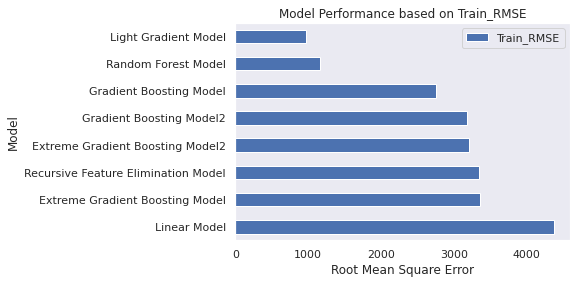

In [ ]:
# Performance based on Train_RMSE
train_perf_sorted= train_perf.sort_values('Train_RMSE', ascending=False)
train_perf_sorted.plot(kind='barh' , x='Model', y='Train_RMSE')
plt.title("Model Performance based on Train_RMSE")
plt.xlabel("Root Mean Square Error")
plt.ylabel("Model")


Text(0, 0.5, 'Model')

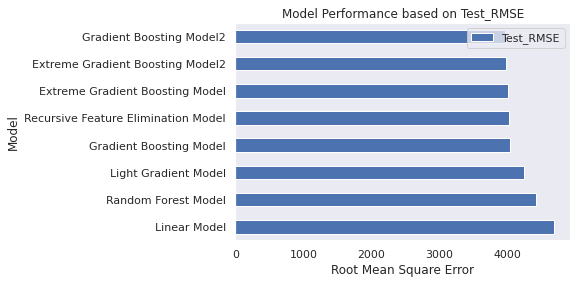

In [ ]:
# Performance based on Test_RMSE
sns.set_style("dark")
test_perf_sorted = train_perf.sort_values('Test_RMSE', ascending=False)
test_perf_sorted.plot(kind='barh' , x='Model', y='Test_RMSE',)
plt.title("Model Performance based on Test_RMSE")
plt.xlabel("Root Mean Square Error")
plt.ylabel("Model")

*Root Mean Square Error (RMSE) is a standard way to measure the error of a model in predicting quantitative data. The lower the RMSE the better the model. Light Gradient Model and the Random forest model have the lowest RMSE when it come to Training data however they are among the model with the Highest RMSE in the Test data indicating that there may be overfitting.*

Text(0, 0.5, 'Model')

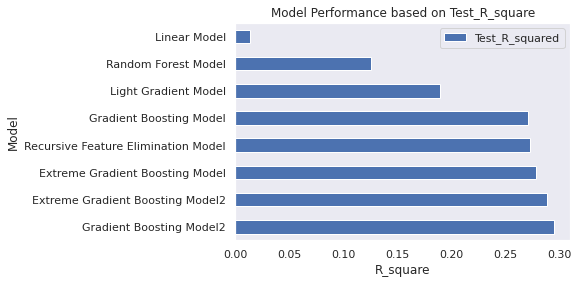

In [ ]:
# Choose best model and motivate why it is the best choice
R_square_perf = performance_df[['Model','Test_R_squared']]
R_square_sorted =R_square_perf.sort_values('Test_R_squared', ascending=False)
R_square_sorted.plot(kind='barh' , x='Model', y='Test_R_squared',)
plt.title("Model Performance based on Test_R_square")
plt.xlabel("R_square")
plt.ylabel("Model")

The best model is the Gradient Boosting Model2 with least squares loss function and a learning rate of 15% as it has the higest R_square at about 30% mean that the model explains about 30% of the variation in the target variable which is the load_shortfall_3h. The model also has the lowest RMSE at 3959.45
The loss function is a measure indicating how good are model’s coefficients are at fitting the underlying data.
The learning rate simply means how fast the model is learning.

<a id="seven"></a>
## 7. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>



**The best model logic**

Gradient boosting method relies on the intuition that the best possible next model, when combined with previous models, minimizes the overall prediction error. It combines the efforts of multiple weak models(decision trees) to create a strong model, and each additional weak model reduces the mean squared error (which the average of the square of the difference between the true targets and the predicted values from a set of observations, such as a training or validation set)of the overall model.
A decision tree is a machine learning model that builds upon iteratively asking questions to partition data and reach a solution. 